# CS5200 Group Project 3: Do Olympic Host Countries Win More Medals? 🥇

Hao Niu, Tianyu Fang, Calvin Lo, Shitai Zhao

This notebook explores the following hypothesis: Countries win more medals when hosting the Olympics.

The data for this analysis comes from: https://www.kaggle.com/datasets/piterfm/olympic-games-medals-19862018


# Introduction

The current project is a data analysis project that aims to explore the performance of host countries in the Olympic Games, from Athens 1896 to Beijing 2022. Data used for the analysis is retrieved from Kaggle, and link to the dataset can be found in the section above. The hypothesis formulated in the project is that countries tend to win more medals when they host the Olympics, which is to some extent a common belief among the general audience, and also a topic that has been discovered and deemed worth exploring by the team during the research phase. As straightforward as the hypothesis itself suggests, the project aims to provide a simple, yet informative analysis of the host country's performance in the Olympic Games, and to offer insights and trends that may be of interest to any potential readers.

The dataset of choice was selected based on the availability of the data, the potential interests of the reader, and the practical considerations such as the time constraints and the complexity of the topic. Having reviewed and compared several datasets related to the same topic, the team eventually landed on the current one, which is considered to be the most comprehensive and detailed dataset available, and is likely to be more engaging and informative to the general audience. For more information on the overall project design and execution, please refer to the relation schema diagram, the follwing notebook sections, and the project appendix.

# 1. Set up

**Import Libraries**

In [ ]:
from collections import Counter
from datetime import datetime
from google.colab import drive
from IPython.display import display
from sqlite3 import Error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3

**Mount Google Drive**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


**Set the locations of the CSV files**

In [ ]:
# Please modify the following directories accordingly while running these commands on different locations
result_data_csv = pd.read_csv('/content/drive/MyDrive/GroupProject3/olympic_results.csv')
medals_data_csv = pd.read_csv('/content/drive/MyDrive/GroupProject3/olympic_medals.csv')
hosts_data_csv =  pd.read_csv('/content/drive/MyDrive/GroupProject3/olympic_hosts.csv')

**Set the location of the desired sqlite3 database file**

In [ ]:
db_file_path = '/content/drive/MyDrive/GroupProject3/olympics.db'

# 2. Connection, helper functions

**Create connection**

In [ ]:
def create_sqlite_connection(path):
  connection = None
  try:
    connection = sqlite3.connect(path)
    print("Connection successful")
  except Error as e:
    print(f"The error '{e}' occurred")
  return connection

sqlite_connection = create_sqlite_connection(db_file_path)

Connection successful


**SQL execution helper**

In [ ]:
def execute_sql_one(connection, query):
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        connection.commit()
    except Error as e:
        print(f"The error '{e}' occurred")
    finally:
        cursor.close()

def execute_sql_multiple(connection, queries):
    try:
        cursor = connection.cursor()
        for query in queries:
            cursor.execute(query)
        connection.commit()
    except Error as e:
        print(f"The error '{e}' occurred")
    finally:
        cursor.close()

**SQL fetch helper** (if needed)

In [ ]:
def execute_sql_fetch(connection, query):
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")
        return None
    finally:
        cursor.close()

# 3. Data cleaning

## 3.1 Standardize name of the country

In [ ]:
# Map the game_location same as the country_name to standardize the name of the country
country_mapping = {
    'United States': 'United States of America',
    'China': 'People\'s Republic of China',
    'Australia, Sweden': 'Australia',
    'USSR': 'Soviet Union'
    }
hosts_data_csv['game_location'] = hosts_data_csv['game_location'].replace(country_mapping)


In [ ]:
unique_host_nations = hosts_data_csv['game_location'].unique()
unique_host_nations

array(["People's Republic of China", 'Japan', 'Republic of Korea',
       'Brazil', 'Russian Federation', 'Great Britain', 'Canada', 'Italy',
       'Greece', 'United States of America', 'Australia', 'Norway',
       'Spain', 'France', 'Yugoslavia', 'Soviet Union', 'Austria',
       'Federal Republic of Germany', 'Mexico', 'Finland', 'Switzerland',
       'Germany', 'Netherlands', 'Belgium', 'Sweden'], dtype=object)

## 3.2 Mapping unique values for discipline title

In [ ]:
unique_discipline_title = medals_data_csv['discipline_title'].unique()
unique_discipline_title

array(['Curling', 'Freestyle Skiing', 'Short Track Speed Skating',
       'Snowboard', 'Ski Jumping', 'Figure skating', 'Luge', 'Ice Hockey',
       'Biathlon', 'Alpine Skiing', 'Skeleton', 'Cross Country Skiing',
       'Speed skating', 'Nordic Combined', 'Bobsleigh', 'Shooting',
       'Diving', 'Canoe Sprint', 'Cycling Road', 'Football', 'Boxing',
       'Artistic Swimming', 'Handball', 'Rugby Sevens',
       'Cycling BMX Racing', 'Triathlon', 'Surfing', 'Table Tennis',
       'Canoe Slalom', 'Marathon Swimming', 'Trampoline Gymnastics',
       'Volleyball', 'Basketball', 'Taekwondo', 'Cycling Track',
       'Fencing', 'Badminton', 'Water Polo', 'Sport Climbing',
       'Wrestling', 'Tennis', 'Artistic Gymnastics', 'Golf',
       'Cycling BMX Freestyle', 'Judo', 'Skateboarding', 'Archery',
       'Weightlifting', 'Baseball/Softball', 'Equestrian',
       'Modern Pentathlon', 'Athletics', 'Swimming', 'Sailing',
       'Cycling Mountain Bike', 'Rowing', 'Karate', '3x3 Basketball',
   

In [ ]:
# Mapping the discipline titles
discipline_mapping = {
    'Artistic Swimming': 'Synchronized Swimming',
    'Artistic Gymnastics': 'Gymnastics Artistic',
    'Rhythmic Gymnastics': 'Gymnastics Rhythmic',
    'Trampoline Gymnastics': 'Trampoline'
}
medals_data_csv['discipline_title'] = medals_data_csv['discipline_title'].replace(discipline_mapping)
result_data_csv['discipline_title'] = result_data_csv['discipline_title'].replace(discipline_mapping)


In [ ]:
# Create a csv file with all the unique event title for each discipline
# unique_events_per_discipline = medals_data_csv.groupby('discipline_title')['event_title'].unique()

# # Convert the Series to a DataFrame for better formatting in CSV
# unique_events_df = unique_events_per_discipline.reset_index()
# unique_events_df['event_title'] = unique_events_df['event_title'].apply(lambda x: ', '.join(x))

# # Save to CSV file
# unique_events_df.to_csv('unique_events_per_discipline.csv', index=False)

# print("Data saved to 'unique_events_per_discipline.csv'")

## 3.3 Mapping event titles

In [ ]:
# Mapping the event titles
event_alpine_skiing_mapping = {
    "Men's Slalom": "Men’s Slalom",
    "Men's Downhill": "Men’s Downhill",
    "Men's Super-G": "Men’s Super-G",
    "Men's Giant Slalom": "Men’s Giant Slalom",
    "Men's Alpine Combined": "Men’s Alpine Combined",
    "Women's Slalom": "Women’s Slalom",
    "Women's Downhill": "Women’s Downhill",
    "Women's Super-G": "Women’s Super-G",
    "Women's Giant Slalom": "Women’s Giant Slalom",
    "Women's Alpine Combined": "Women’s Alpine Combined",
    "Ladies’ Slalom": "Women’s Slalom",
    "Ladies’ Downhill": "Women’s Downhill",
    "Ladies’ Super-G": "Women’s Super-G",
    "Ladies’ Giant Slalom": "Women’s Giant Slalom",
    "Ladies’ Alpine Combined": "Women’s Alpine Combined",
    "Mixed Team Parallel": "Mixed Team Parallel",
    "Alpine Team Event": "Alpine Team Event",
    "super-G women": "Women’s Super-G",
    "super-G men": "Men’s Super-G",
    "alpine combined women": "Women’s Alpine Combined",
    "giant slalom women": "Women’s Giant Slalom",
    "giant slalom men": "Men’s Giant Slalom",
    "downhill men": "Men’s Downhill",
    "downhill women": "Women’s Downhill",
    "slalom women": "Women’s Slalom",
    "alpine combined men": "Men’s Alpine Combined",
    "slalom men": "Men’s Slalom",
    "alpin combined men": "Men’s Alpine Combined",

}

result_data_csv.loc[result_data_csv['discipline_title'] == 'Alpine Skiing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Alpine Skiing']['event_title'].replace(event_alpine_skiing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Alpine Skiing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Alpine Skiing']['event_title'].replace(event_alpine_skiing_mapping)


In [ ]:
event_archery_mapping = {
    "Women's Individual": "Individual Competition Women",
    "Men's Individual": "Individual Competition Men",
    "Women's Team": "Team Competition Women",
    "Mixed Team": "Mixed Team",
    "Men's Team": "Team Competition Men",
    "team competition women": "Team Competition Women",
    "Individual competition men": "Individual Competition Men",
    "Individual Competition women": "Individual Competition Women",
    "team competition men": "Team Competition Men",
    "individual FITA Olympic round  70m men": "Individual Competition Men",
    "individual FITA Olympic round  70m women": "Individual Competition Women",
    "team FITA Olympic round  70m women": "Team Competition Women",
    "team FITA Olympic round  70m men": "Team Competition Men",
    "individual FITA round men": "Individual Competition Men",
    "individual FITA round women": "Individual Competition Women",
    "teams FITA round women": "Team Competition Women",
    "teams FITA round men": "Team Competition Men",
    "moving bird target 33m men": "Moving Bird Target 33m Men",
    "moving bird target 28m men": "Moving Bird Target 28m Men",
    "moving bird target 50m teams men": "Moving Bird Target 50m Teams Men",
    "moving bird target 33m teams men": "Moving Bird Target 33m Teams Men",
    "fixed bird target small bird teams men": "Fixed Bird Target Small Bird Teams Men",
    "fixed bird target large birds men": "Fixed Bird Target Large Birds Men",
    "moving bird target 50m men": "Moving Bird Target 50m Men",
    "moving bird target 28m teams men": "Moving Bird Target 28m Teams Men",
    "fixed bird target small birds men": "Fixed Bird Target Small Birds Men",
    "fixed bird target large birds teams men": "Fixed Bird Target Large Birds Teams Men",
    "york round (100y - 80y - 60y) men": "York Round Men",
    "national round 60y  50y women": "National Round Women",
    "continental style 50m men": "Continental Style 50m Men",
    "Team Round Men": "Team Round Men",
    "double national round 60y  50y women": "Double National Round Women",
    "double york round 100y  80y  60y men": "Double York Round Men",
    "double columbia round 50y  40y  30y women": "Double Columbia Round Women",
    "double american round (60y - 50y - 40y) men": "Double American Round Men",
    "Championnat Du Monde Men": "World Championship Men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Archery', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Archery']['event_title'].replace(event_archery_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Archery', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Archery']['event_title'].replace(event_archery_mapping)

In [ ]:
athletics_mapping = {
    "Women's 1500m": "1500m women",
    "Men's Triple Jump": "triple jump men",
    "Women's 3000m Steeplechase": "3000m steeplechase women",
    "Women's 4 x 100m Relay": "4x100m relay women",
    "Men's Shot Put": "shot put men",
    "Women's Long Jump": "long jump women",
    "Women's 5000m": "5000m women",
    "Men's Marathon": "marathon men",
    "Women's Javelin Throw": "javelin throw women",
    "Men's 110m Hurdles": "110m hurdles men",
    "Men's Long Jump": "long jump men",
    "Men's Javelin Throw": "javelin throw men",
    "Men's 50km Race Walk": "50km walk men",
    "Men's 200m": "200m men",
    "Women's 400m": "400m women",
    "Women's 100m": "100m women",
    "Women's Marathon": "marathon women",
    "Women's Triple Jump": "triple jump women",
    "Men's 800m": "800m men",
    "Women's Shot Put": "shot put women",
    "Women's 20km Race Walk": "20km race walk women",
    "Women's Pole Vault": "pole vault women",
    "Women's Hammer Throw": "hammer throw women",
    "Women's 100m Hurdles": "100m hurdles women",
    "Men's High Jump": "high jump men",
    "Women's Discus Throw": "discus throw women",
    "Women's 4 x 400m Relay": "4x400m relay women",
    "Women's 10,000m": "10000m women",
    "Men's Hammer Throw": "hammer throw men",
    "Men's 3000m Steeplechase": "3000m steeplechase men",
    "Women's 800m": "800m women",
    "Men's Decathlon": "decathlon men",
    "Men's 100m": "100m men",
    "Men's Pole Vault": "pole vault men",
    "Women's 400m Hurdles": "400m hurdles women",
    "Men's 10,000m": "10000m men",
    "Men's 400m Hurdles": "400m hurdles men",
    "Men's Discus Throw": "discus throw men",
    "Men's 4 x 100m Relay": "4x100m relay men",
    "Women's 200m": "200m women",
    "Women's High Jump": "high jump women",
    "Men's 4 x 400m Relay": "4x400m relay men",
    "Men's 20km Race Walk": "20km walk men",
    "Men's 400m": "400m men",
    "Women's Heptathlon": "heptathlon women",
    "Men's 1500m": "1500m men",
    "Men's 5000m": "5000m men"
}

result_data_csv.loc[result_data_csv['discipline_title'] == 'Athletics', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Athletics']['event_title'].replace(athletics_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Athletics', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Athletics']['event_title'].replace(athletics_mapping)

In [ ]:
badminton_mapping = {
    "Men's Doubles": "doubles men",
    "Women's Doubles": "doubles women",
    "Mixed Doubles": "Doubles mixed",
    "Men's Singles": "Singles men",
    "Women's Singles": "Singles women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Badminton', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Badminton']['event_title'].replace(badminton_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Badminton', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Badminton']['event_title'].replace(badminton_mapping)

In [ ]:
basketball_mapping = {
    'Men': 'basketball men',
    'Women': 'basketball women'
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Basketball', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Basketball']['event_title'].replace(basketball_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Basketball', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Basketball']['event_title'].replace(basketball_mapping)

In [ ]:
beach_volleyball_mapping = {
    'Women': 'Beach volleyball women',
    'Men': 'Beach volleyball men'
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Beach Volleyball', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Beach Volleyball']['event_title'].replace(beach_volleyball_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Beach Volleyball', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Beach Volleyball']['event_title'].replace(beach_volleyball_mapping)


In [ ]:
biathlon_mapping = {
    "Men's 12.5km Pursuit": "12.5km pursuit men",
    "Mixed Relay 4x6km (W+M)": "Relay mix mixed",
    "Women's 12.5km Mass Start": "12.5km mass start women",
    "Women's 10km Pursuit": "10km pursuit women",
    "Men's 10km Sprint": "10km men",
    "Women's 7.5km Sprint": "7.5km women",
    "Women's 4x6km Relay": "4x6km relay women",
    "Men's 15km Mass Start": "15km mass start men",
    "Men's 20km Individual": "20km men",
    "Men's 4x7.5km Relay": "4x7.5km relay men",
    "Women's 15km Individual": "15km women",
    "2x6km Women + 2x7.5km Men Mixed Relay": "Relay mix mixed",
    "Men’s 20km Individual": "20km men",
    "Women’s 15km Individual": "15km women",
    "Men’s 10km Sprint": "10km men",
    "Men’s 12.5km Pursuit": "12.5km pursuit men",
    "Women’s 7.5km Sprint": "7.5km women",
    "Women’s 12.5km Mass Start": "12.5km mass start women",
    "Men’s 4x7.5km Relay": "4x7.5km relay men",
    "Women’s 10km Pursuit": "10km pursuit women",
    "Women’s 4x6km Relay": "4x6km relay women",
    "Men’s 15km Mass Start": "15km mass start men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Biathlon', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Biathlon']['event_title'].replace(biathlon_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Biathlon', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Biathlon']['event_title'].replace(biathlon_mapping)


In [ ]:
bobsleigh_mapping = {
    "4-man": "four-man men",
    "Women's Monobob": "Women’s Bobsleigh",
    "2-man": "two-man men",
    "2-woman": "two-woman women",
    "Women’s Bobsleigh": "Women’s Bobsleigh",
    "Four-man": "four-man men",
    "Two-man": "two-man men",
    "two-man men": "two-man men",
    "two-woman women": "two-woman women",
    "four-man men": "four-man men",
    "twoman men": "two-man men",
    "fourman men": "four-man men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Bobsleigh', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Bobsleigh']['event_title'].replace(bobsleigh_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Bobsleigh', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Bobsleigh']['event_title'].replace(bobsleigh_mapping)


In [ ]:
boxing_mapping = {
    "+ 91kg (super heavyweight) men": "Men's Super Heavy (+91kg)",
    "75 - 81kg (light-heavyweight) men": "Men's Light Heavy (75-81kg)",
    "46-49kg men": "Men's Fly (48-52kg)",
    "52kg men": "Men's Fly (48-52kg)",
    "60 kg light women": "Women's Light (57-60kg)",
    "81-91kg heavyweight men": "Men's Heavy (81-91kg)",
    "69 - 75 kg men": "Men's Middle (69-75kg)",
    "64 - 69 kg men": "Men's Welter (63-69kg)",
    "51 kg fly women": "Women's Fly (48-51kg)",
    "75 kg middle women": "Women's Middle (69-75kg)",
    "56kg men": "Men's Feather (52-57kg)",
    "60 - 64 kg men": "Men's Welter (63-69kg)",
    "57-60kg lightweight men": "Men's Light (57-63kg)",
    "75-81kg lightheavyweight men": "Men's Light Heavy (75-81kg)",
    "48-51kg flyweight men": "Men's Fly (48-52kg)",
    "48kg light flyweight men": "Men's Fly (48-52kg)",
    "54-57kg featherweight men": "Men's Feather (52-57kg)",
    "91kg super heavyweight men": "Men's Super Heavy (+91kg)",
    "51-54kg bantamweight men": "Men's Bantam (51-54kg)",
    "48kg lightflyweight men": "Men's Fly (48-52kg)",
    "63.5-67kg welterweight men": "Men's Welter (63-69kg)",
    "71-75kg men": "Men's Middle (69-75kg)",
    "67-71kg lightmiddleweight men": "Men's Light Middle (67-71kg)",
    "60-63.5kg lightwelterweight men": "Men's Light Welter (60-64kg)",
    "81kg heavyweight men": "Men's Heavy (81-91kg)",
    "63.5 - 67kg (welterweight) men": "Men's Welter (63-69kg)",
    "- 48kg (light-flyweight) men": "Men's Fly (48-52kg)",
    "62-67kg welterweight men": "Men's Welter (63-69kg)",
    "80kg heavyweight men": "Men's Heavy (81-91kg)",
    "58-62kg lightweight men": "Men's Light (57-63kg)",
    "54-58kg (featherweight) men": "Men's Feather (52-57kg)",
    "73-80kg lightheavyweight men": "Men's Light Heavy (75-81kg)",
    "67-73kg middleweight men": "Men's Middle (69-75kg)",
    "Flyweight men": "Men's Fly (48-52kg)",
    "Lightheavyweight men": "Men's Light Heavy (75-81kg)",
    "Heavyweight men": "Men's Heavy (81-91kg)",
    "Middleweight men": "Men's Middle (69-75kg)",
    "bantamweight men": "Men's Bantam (51-54kg)",
    "Lightweight men": "Men's Light (57-63kg)",
    "Welterweight men": "Men's Welter (63-69kg)",
    "Featherweight men": "Men's Feather (52-57kg)"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Boxing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Boxing']['event_title'].replace(boxing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Boxing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Boxing']['event_title'].replace(boxing_mapping)

In [ ]:
canoe_slalom_mapping = {
    "Men's Kayak": "K1 kayak single men",
    "Women's Kayak": "K1 kayak single women",
    "Men's Canoe": "C1 canoe single men",
    "K-1 (kayak single) men": "K1 kayak single men",
    "K-1 (kayak single) women": "K1 kayak single women",
    "C-1 (canoe single) men": "C1 canoe single men",
    "C-2 (canoe double) men": "C2 canoe double men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Canoe Slalom', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Canoe Slalom']['event_title'].replace(canoe_slalom_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Canoe Slalom', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Canoe Slalom']['event_title'].replace(canoe_slalom_mapping)

In [ ]:
canoe_sprint_mapping = {
    "Men's Canoe Double 1000m": "C-2 1000m (canoe double) men",
    "Men's Kayak Double 1000m": "K-2 1000m (kayak double) men",
    "Women's Kayak Single 200m": "K-1 200m (kayak single) women",
    "Women's Kayak Single 500m": "K-1 500m (kayak single) women",
    "Women's Kayak Four 500m": "K-4 500m (kayak four) women",
    "Men's Canoe Single 1000m": "C-1 1000m (canoe single) men",
    "Men's Kayak Single 1000m": "K-1 1000m (kayak single) men",
    "Women's Kayak Double 500m": "K-2 500m (kayak double) women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Canoe Sprint', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Canoe Sprint']['event_title'].replace(canoe_sprint_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Canoe Sprint', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Canoe Sprint']['event_title'].replace(canoe_sprint_mapping)

In [ ]:
cross_country_skiing_mapping = {
    "Women's Sprint Free": "sprint 15km women",
    "Women's Team Sprint Classic": "Team sprint women",
    "Men's Team Sprint Classic": "Team sprint men",
    "Men's 15km + 15km Skiathlon": "Skiathlon 15km  15km men",
    "Men's 4 x 10km Relay": "Relay 4x10km men",
    "Women's 7.5km + 7.5km Skiathlon": "Skiathlon 7.5+7.5km women",
    "Women's 30km Mass Start Free": "30km women",
    "Women's 10km Classic": "10km women",
    "Men's 50km Mass Start Free": "50km men",
    "Men's 15km Classic": "15km men",
    "Women's 4 x 5km Relay": "Relay 4x5km women",
    "Men's Sprint Free": "sprint 15km men",
    "Ladies’ 4x5km Relay": "Relay 4x5km women",
    "Men’s Sprint Classic": "sprint 15km men",
    "Men’s 15km Free": "15km men",
    "Men’s 4x10km Relay": "Relay 4x10km men",
    "Ladies’ 10km Free": "10km women",
    "Men’s 15km+15km Skiathlon": "Skiathlon 15km  15km men",
    "Men’s 50km Mass Start Classic": "50km men",
    "Ladies’ 7.5km+7.5km Skiathlon": "Skiathlon 7.5+7.5km women",
    "Ladies’ Team Sprint Free": "Team sprint women",
    "Ladies’ Sprint Classic": "sprint 15km women",
    "Men’s Team Sprint Free": "Team sprint men",
    "Ladies’ 30km Mass Start Classic": "30km women",
    "Team sprint men": "Team sprint men",
    "Relay 4x5km women": "Relay 4x5km women",
    "Team sprint women": "Team sprint women",
    "Relay 4x10km men": "Relay 4x10km men",
    "30km mass start men": "30km men",
    "15km mass start women": "15km women",
    "Combined 5km  10km pursuit women": "5km pursuit women",
    "Combined 10km  15km pursuit men": "10km pursuit men",
    "5km women": "5km pursuit women",
    "20km women": "20km women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Cross Country Skiing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Cross Country Skiing']['event_title'].replace(cross_country_skiing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Cross Country Skiing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Cross Country Skiing']['event_title'].replace(cross_country_skiing_mapping)

In [ ]:
curling_mapping = {
    'Women': 'curling women',
    'Men': 'curling men'
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Curling', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Curling']['event_title'].replace(curling_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Curling', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Curling']['event_title'].replace(curling_mapping)

In [ ]:
cycling_mountain_bike_mapping = {
    "Women's Cross-country": "cross-country women",
    "Men's Cross-country": "cross-country men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Cycling Mountain Bike', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Cycling Mountain Bike']['event_title'].replace(cycling_mountain_bike_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Cycling Mountain Bike', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Cycling Mountain Bike']['event_title'].replace(cycling_mountain_bike_mapping)

In [ ]:
cycling_road_mapping = {
    "Women's Road Race": "individual road race women",
    "Women's Individual Time Trial": "individual time trial women",
    "Men's Individual Time Trial": "individual time trial men",
    "Men's Road Race": "individual road race men",
    "team time trial men": "team time trial men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Cycling Road', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Cycling Road']['event_title'].replace(cycling_road_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Cycling Road', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Cycling Road']['event_title'].replace(cycling_road_mapping)

In [ ]:
cycling_track_mapping = {
    "Women's Team Sprint": "Team sprint women",
    "Men's Madison": "Madison men",
    "Men's Sprint": "Sprint men",
    "Men's Keirin": "Keirin men",
    "Men's Team Pursuit": "Team Pursuit 4000m men",
    "Women's Keirin": "Keirin women",
    "Women's Sprint": "sprint women",
    "Women's Team Pursuit": "Team Pursuit 3000m women",
    "Men's Team Sprint": "Team sprint men",
    "Men's Omnium": "Omnium men",
    "Women's Omnium": "Omnium women",
    "points race women": "points race women",
    "individual pursuit women": "Individual Pursuit women",
    "Individual Pursuit men": "Individual Pursuit men",
    "Points Race men": "Points Race men",
    "1km time trial men": "1km time trial men",
    "500m time trial women": "500m time trial women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Cycling Track', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Cycling Track']['event_title'].replace(cycling_track_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Cycling Track', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Cycling Track']['event_title'].replace(cycling_track_mapping)

In [ ]:
diving_mapping = {
    "Men's Synchronised 3m Springboard": "synchronized diving 3m springboard men",
    "Women's Synchronised 3m Springboard": "synchronized diving 3m springboard women",
    "Men's Synchronised 10m Platform": "synchronized diving 10m platform men",
    "Men's 3m Springboard": "3m springboard men",
    "Women's Synchronised 10m Platform": "synchronized diving 10m platform women",
    "Women's 10m Platform": "10m platform women",
    "Men's 10m Platform": "10m platform men",
    "Women's 3m Springboard": "3m springboard women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Diving', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Diving']['event_title'].replace(diving_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Diving', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Diving']['event_title'].replace(diving_mapping)

In [ ]:
equestrian_eventing_mapping = {
    "Eventing Team mixed": "team mixed",
    "Eventing Individual mixed": "individual mixed"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Equestrian Eventing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Equestrian Eventing']['event_title'].replace(equestrian_eventing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Equestrian Eventing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Equestrian Eventing']['event_title'].replace(equestrian_eventing_mapping)

In [ ]:
figure_skating_mapping = {
    "Team Event": "team mixed",
    "Pair Skating": "Pairs mixed",
    "Ice Dance": "Ice dancing mixed",
    "Women Single Skating": "Ladies' Single Skating",
    "Men Single Skating": "Men's Single Skating",
    "Team event": "team mixed",
    "Individual women": "Ladies' Single Skating",
    "Individual men": "Men's Single Skating"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Figure Skating', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Figure Skating']['event_title'].replace(figure_skating_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Figure Skating', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Figure Skating']['event_title'].replace(figure_skating_mapping)

In [ ]:
foorball_mapping = {
    'Women': 'football women',
    'Men': 'football men'
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Football', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Football']['event_title'].replace(foorball_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Football', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Football']['event_title'].replace(foorball_mapping)


In [ ]:
freestyle_skiing_mapping = {
    "Men's Moguls": "Moguls men",
    "Men's Freeski Halfpipe": "Men’s Ski Halfpipe",
    "Men's Ski Cross": "Ski Cross men",
    "Women's Freeski Big Air": "Ski Slopestyle women",
    "Women's Moguls": "Moguls women",
    "Women's Ski Cross": "Ski Cross women",
    "Men's Aerials": "Aerials men",
    "Women's Aerials": "Aerials women",
    "Women's Freeski Halfpipe": "Women’s Ski Halfpipe",
    "Women's Freeski Slopestyle": "Ski Slopestyle women",
    "Men's Freeski Slopestyle": "Ski Slopestyle men",
    "Ladies’ Ski Slopestyle": "Ski Slopestyle women",
    "Ladies’ Aerials": "Aerials women",
    "Ladies’ Moguls": "Moguls women",
    "Ladies’ Ski Cross": "Ski Cross women",
    "Ladies’ Ski Halfpipe": "Women’s Ski Halfpipe"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Freestyle Skiing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Freestyle Skiing']['event_title'].replace(freestyle_skiing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Freestyle Skiing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Freestyle Skiing']['event_title'].replace(freestyle_skiing_mapping)

In [ ]:
golf_mapping = {
    "Women's Individual Stroke Play": "Individual women",
    "Men's Individual Stroke Play": "Individual men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Golf', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Golf']['event_title'].replace(golf_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Golf', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Golf']['event_title'].replace(golf_mapping)

In [ ]:
gymnastics_artistic_mapping = {
    "Women's Vault": "vault women",
    "Men's All-Around": "individual all-round men",
    "Women's Balance Beam": "balance beam women",
    "Women's All-Around": "individual all-round women",
    "Men's Team": "team competition men",
    "Women's Team": "team competition women",
    "Men's Horizontal Bar": "horizontal bar men",
    "Men's Pommel Horse": "pommel horse men",
    "Men's Vault": "vault men",
    "Women's Floor Exercise": "floor exercises women",
    "Women's Uneven Bars": "uneven bars women",
    "Men's Parallel Bars": "parallel bars men",
    "Men's Floor Exercise": "floor exercises men",
    "Men's Rings": "rings men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Gymnastics Artistic', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Gymnastics Artistic']['event_title'].replace(gymnastics_artistic_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Gymnastics Artistic', 'event_title'] = medals_data_csv[result_data_csv['discipline_title'] == 'Gymnastics Artistic']['event_title'].replace(gymnastics_artistic_mapping)

<ipython-input-35-20892190f44b>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Gymnastics Artistic', 'event_title'] = medals_data_csv[result_data_csv['discipline_title'] == 'Gymnastics Artistic']['event_title'].replace(gymnastics_artistic_mapping)


In [ ]:
gymnastics_rhythmic_mapping = {
    "Individual All-Around": "individual all-round women",
    "Group All-Around": "group competition women",
    "Group All-Around women": "group competition women",
    "Individual All-Around women": "individual all-round women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Gymnastics Rhythmic', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Gymnastics Rhythmic']['event_title'].replace(gymnastics_rhythmic_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Gymnastics Rhythmic', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Gymnastics Rhythmic']['event_title'].replace(gymnastics_rhythmic_mapping)


In [ ]:
handball_mapping = {
    "Men": "handball men",
    "Women": "handball women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Handball', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Handball']['event_title'].replace(handball_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Handball', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Handball']['event_title'].replace(handball_mapping)

In [ ]:
hockey_mapping = {
    "Men": "hockey men",
    "Women": "hockey women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Hockey', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Hockey']['event_title'].replace(hockey_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Hockey', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Hockey']['event_title'].replace(hockey_mapping)

In [ ]:
ice_hockey_mapping = {
    "Men": "ice hockey men",
    "Women": "ice hockey women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Ice Hockey', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Ice Hockey']['event_title'].replace(ice_hockey_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Ice Hockey', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Ice Hockey']['event_title'].replace(ice_hockey_mapping)

In [ ]:
judo_mapping = {
    "Mixed Team": "Mixed Team",
    "Women -57 kg": "52 - 57kg lightweight women",
    "Women +78 kg": "+ 78kg (heavyweight) women",
    "Women -70 kg": "63  70kg middleweight women",
    "Women -78 kg": "70 - 78kg (half-heavyweight) women",
    "Men -81 kg": "73  81kg halfmiddleweight men",
    "Men -66 kg": "60 - 66kg (half-lightweight) men",
    "Men -73 kg": "66  73kg lightweight men",
    "Women -48 kg": "- 48 kg women",
    "Men +100 kg": "+ 100kg (heavyweight) men",
    "Men -90 kg": "81  90kg middleweight men",
    "Men -100 kg": "90 - 100kg (half-heavyweight) men",
    "Men -60 kg": "- 60 kg men",
    "Women -63 kg": "57 - 63kg (half-middleweight) women",
    "Women -52 kg": "48 - 52kg (half-lightweight) women",
    "70 - 78kg (half-heavyweight) women": "Women -78 kg",
    "- 48 kg women": "Women -48 kg",
    "60 - 66kg (half-lightweight) men": "Men -66 kg",
    "63  70kg middleweight women": "Women -70 kg",
    "52  57kg lightweight women": "Women -57 kg",
    "81  90kg middleweight men": "Men -90 kg",
    "+ 100kg (heavyweight) men": "Men +100 kg",
    "90 - 100kg (half-heavyweight) men": "Men -100 kg",
    "- 60 kg men": "Men -60 kg",
    "73 - 81kg (half-middleweight) men": "Men -81 kg",
    "57 - 63kg (half-middleweight) women": "Women -63 kg",
    "+ 78kg (heavyweight) women": "Women +78 kg",
    "66  73kg lightweight men": "Men -73 kg",
    "48 - 52kg (half-lightweight) women": "Women -52 kg",
    "48  52kg halflightweight women": "Women -52 kg",
    "60  66kg halflightweight men": "Men -66 kg",
    "78kg heavyweight women": "Women +78 kg",
    "60 kg men": "Men -60 kg",
    "100kg heavyweight men": "Men +100 kg",
    "- 60 kg -extralightweight men": "Men -60 kg",
    "- 48 kg - extralightweight women": "Women -48 kg",
    "73  81kg halfmiddleweight men": "Men -81 kg",
    "57  63kg halfmiddleweight women": "Women -63 kg",
    "48kg extralightweight women": "Women -48 kg",
    "66  72kg halfheavyweight women": "Women -78 kg",
    "56  61kg halfmiddleweight women": "Women -63 kg",
    "61  66kg middleweight women": "Women -70 kg",
    "78  86kg middleweight men": "Men -90 kg",
    "86  95kg halfheavyweight men": "Men -100 kg",
    "60 - 65kg (half-lightweight) men": "Men -66 kg",
    "+ 95kg (heavyweight) men": "Men +100 kg",
    "71 - 78kg (half-middleweight) men": "Men -81 kg",
    "65 - 71kg (lightweight) men": "Men -73 kg",
    "95kg heavyweight men": "Men +100 kg",
    "71  78kg halfmiddleweight men": "Men -81 kg",
    "open category men": "Men +100 kg",
    "60  65kg halflightweight men": "Men -66 kg",
    "63  70kg halfmiddleweight men": "Men -73 kg",
    "80 - 93kg (half-heavyweight) men": "Men -90 kg",
    "70  80kg middleweight men": "Men -90 kg",
    "93kg heavyweight men": "Men +100 kg",
    "- 63kg (lightweight) men": "Men -66 kg",
    "63kg lightweight men": "Men -66 kg",
    "68kg lightweight men": "Men -73 kg",
    "80kg heavyweight men": "Men +100 kg",
    "68  80kg middleweight men": "Men -90 kg"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Judo', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Judo']['event_title'].replace(judo_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Judo', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Judo']['event_title'].replace(judo_mapping)

In [ ]:
luge_mapping = {
    "Team Relay": "Mixed Team Relay mixed",
    "Doubles": "Doubles mixed",
    "Men's Singles": "Singles men",
    "Women's Singles": "Singles women",
    "Women’s Singles": "Singles women",
    "Men’s Singles": "Singles men",
    "Singles women": "Women's Singles",
    "Mixed Team Relay mixed": "Team Relay",
    "Doubles mixed": "Doubles",
    "Singles men": "Men's Singles"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Luge', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Luge']['event_title'].replace(luge_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Luge', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Luge']['event_title'].replace(luge_mapping)

In [ ]:
marathon_swimming_mapping = {
    "Women's 10km": "marathon 10km women",
    "Men's 10km": "Marathon - 10 km men",
    "Marathon - 10 km men": "Men's 10km",
    "Marathon - 10 km women": "Women's 10km",
    "marathon 10km women": "Women's 10km"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Marathon Swimming', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Marathon Swimming']['event_title'].replace(marathon_swimming_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Marathon Swimming', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Marathon Swimming']['event_title'].replace(marathon_swimming_mapping)

In [ ]:
modern_pentathlon_mapping = {
    "Men's Individual": "Individual competition men",
    "Women's Individual": "Individual Competition women",
    "Individual Competition women": "Women's Individual",
    "Individual competition men": "Men's Individual",
    "team competition men": "Men's Individual"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Modern Pentathlon', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Modern Pentathlon']['event_title'].replace(modern_pentathlon_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Modern Pentathlon', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Modern Pentathlon']['event_title'].replace(modern_pentathlon_mapping)

In [ ]:
nordic_combined_mapping = {
    "Individual Gundersen Normal Hill/10km": "Individual men",
    "Individual Gundersen Large Hill/10km": "Individual LH men",
    "Team Gundersen Large Hill/4x5km": "Team men",
    "Individual men": "Individual Gundersen Normal Hill/10km",
    "Individual LH men": "Individual Gundersen Large Hill/10km",
    "Team men": "Team Gundersen Large Hill/4x5km",
    "Individual sprint men": "Individual Gundersen Large Hill/10km",
    "Team Men": "Team Gundersen Large Hill/4x5km"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Nordic Combined', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Nordic Combined']['event_title'].replace(nordic_combined_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Nordic Combined', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Nordic Combined']['event_title'].replace(nordic_combined_mapping)

In [ ]:
rowing_mapping = {
    "Women's Double Sculls": "double sculls 2x women",
    "Lightweight Women's Double Sculls": "lightweight double sculls 2x women",
    "Women's Eight": "eight with coxswain 8 women",
    "Men's Eight": "eight with coxswain 8 men",
    "Men's Quadruple Sculls": "quadruple sculls without coxswain (4x) men",
    "Women's Quadruple Sculls": "quadruple sculls without coxswain (4x) women",
    "Men's Pair": "pair without coxswain 2 men",
    "Women's Pair": "pair without coxswain 2 women",
    "Women's Four": "coxless four 4 women",
    "Women's Single Sculls": "single sculls 1x women",
    "Lightweight Men's Double Sculls": "lightweight double sculls 2x men",
    "Men's Four": "four without coxswain 4 men",
    "Men's Double Sculls": "double sculls 2x men",
    "Men's Single Sculls": "single sculls 1x men",
    "lightweight double sculls 2x men": "Lightweight Men's Double Sculls",
    "four without coxswain 4 men": "Men's Four",
    "double sculls 2x men": "Men's Double Sculls",
    "single sculls 1x men": "Men's Single Sculls",
    "double sculls 2x women": "Women's Double Sculls",
    "quadruple sculls without coxswain (4x) women": "Women's Quadruple Sculls",
    "lightweight coxless four 4 men": "Men's Four",
    "eight with coxswain 8 men": "Men's Eight",
    "eight with coxswain 8 women": "Women's Eight",
    "single sculls 1x women": "Women's Single Sculls",
    "lightweight double sculls 2x women": "Lightweight Women's Double Sculls",
    "pair without coxswain 2 men": "Men's Pair",
    "pair without coxswain 2 women": "Women's Pair",
    "quadruple sculls without coxswain (4x) men": "Men's Quadruple Sculls",
    "quadruple sculls without coxsw men": "Men's Quadruple Sculls",
    "quadruple sculls without coxsw women": "Women's Quadruple Sculls",
    "coxless four 4 women": "Women's Four",
    "four-oared shell with coxswain men": "Men's Eight",
    "pair-oared shell with coxswain men": "Men's Pair",
    "Quadruple Sculls Men": "Men's Quadruple Sculls",
    "fouroared shell with coxswain 4 women": "Women's Eight",
    "quadruple sculls with coxswain women": "Women's Quadruple Sculls",
    "quadruple sculls with coxswain 4x men": "Men's Quadruple Sculls",
    "Coxed Eights Men": "Men's Eight",
    "Coxless Pairs Men": "Men's Pair",
    "Coxless Fours Men": "Men's Four",
    "Double Sculls Men": "Men's Double Sculls",
    "four-oared shell with coxswain men - Final 2": "Men's Eight",
    "four-oared shell with coxswain men - Final 1": "Men's Eight"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Rowing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Rowing']['event_title'].replace(rowing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Rowing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Rowing']['event_title'].replace(rowing_mapping)

In [ ]:
sailing_mapping = {
    "Finn Men": "Finn - One Person Dinghy (Heavyweight) men",
    "470 Men": "470 - Two Person Dinghy men",
    "Laser Radial Women": "Laser Radial - One Person Dinghy women",
    "Nacra 17 Mixed": "Nacra 17 Mixed mixed",
    "49er FX Women": "49er FX Women women",
    "Laser Men": "Laser - One Person Dinghy men",
    "RS:X Men": "RS:X - Windsurfer men",
    "RS:X Women": "RS:X - Windsurfer women",
    "470 Women": "470 - Two Person Dinghy women",
    "49er Men": "49er - Skiff men",
    "49er FX Women women": "49er FX Women",
    "RS:X - Windsurfer women": "RS:X Women",
    "RS:X - Windsurfer men": "RS:X Men",
    "Finn - One Person Dinghy (Heavyweight) men": "Finn Men",
    "49er - Skiff men": "49er Men",
    "49er - Skiff mixed": "49er Men",
    "Mistral - Windsurfer men": "RS:X Men",
    "singlehanded dinghy Europe women": "Laser Radial Women",
    "single-handed dinghy open (Laser) mixed": "Laser Men",
    "board Mistral women": "RS:X Women",
    "fleetmatch race keelboat open Soling mixed": "Nacra 17 Mixed",
    "twoperson keelboat open Star mixed": "Nacra 17 Mixed",
    "single-handed dinghy (Europe) women": "Laser Radial Women",
    "flying dutchman mixed": "Nacra 17 Mixed",
    "board lechner women": "RS:X Women",
    "Lechner - Windsurfer men": "RS:X Men",
    "Division II - Windsurfer men": "RS:X Men",
    "Windglider - Windsurfer men": "RS:X Men",
    "tempest mixed": "Nacra 17 Mixed",
    "dragon mixed": "Nacra 17 Mixed",
    "5.5m mixed": "Nacra 17 Mixed",
    "sharpie 12m2 mixed": "Nacra 17 Mixed",
    "6m mixed": "Nacra 17 Mixed",
    "firefly class mixed": "Nacra 17 Mixed",
    "swallow golondrina mixed": "Nacra 17 Mixed",
    "8m mixed": "Nacra 17 Mixed",
    "olympic class monotype mixed": "Nacra 17 Mixed",
    "12m rating 1919 mixed": "Nacra 17 Mixed",
    "7m mixed": "Nacra 17 Mixed",
    "40m sq mixed": "Nacra 17 Mixed",
    "12m rating 1907 mixed": "Nacra 17 Mixed",
    "6m rating 1919 men": "Nacra 17 Mixed",
    "8m rating 1907 mixed": "Nacra 17 Mixed",
    "65m rating 1919 mixed": "Nacra 17 Mixed",
    "30m sq mixed": "Nacra 17 Mixed",
    "10m rating 1919 mixed": "Nacra 17 Mixed",
    "12 foot dinghy mixed": "Nacra 17 Mixed",
    "8m rating 1919 men": "Nacra 17 Mixed",
    "6m rating 1907 mixed": "Nacra 17 Mixed",
    "10m rating 1907 mixed": "Nacra 17 Mixed",
    "10m mixed": "Nacra 17 Mixed",
    "12m mixed": "Nacra 17 Mixed",
    "0.5-1t mixed": "Nacra 17 Mixed",
    "10-20t mixed": "Nacra 17 Mixed",
    "1-2 Ton Race One Open": "Nacra 17 Mixed",
    "open class mixed": "Nacra 17 Mixed",
    "1-2t mixed": "Nacra 17 Mixed",
    "0.5t mixed": "Nacra 17 Mixed",
    "race one": "Nacra 17 Mixed",
    "2-3 Ton Race Two Open": "Nacra 17 Mixed",
    "3-10 Ton Race One Open": "Nacra 17 Mixed",
    "0.5t mixed": "Nacra 17 Mixed",
    "race two": "Nacra 17 Mixed",
    "3-10t mixed": "Nacra 17 Mixed",
    "½-1 Ton Race Two Open": "Nacra 17 Mixed",
    "2-3t mixed": "Nacra 17 Mixed",
    "20t + mixed": "Nacra 17 Mixed"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Sailing', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Sailing']['event_title'].replace(sailing_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Sailing', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Sailing']['event_title'].replace(sailing_mapping)

In [ ]:
shooting_mapping = {
    "Trap Mixed Team": "trap (125 targets) mixed",
    "50m Rifle 3 Positions women": "50m rifle 3 positions 3x20 shots women",
    "50m Rifle 3 Positions Men": "50m rifle 3 positions 3x40 shots men",
    "25m Rapid Fire Pistol Men": "25m rapid fire pistol 60 shots men",
    "10m Air Rifle Men": "10m air rifle 60 shots men",
    "10m Air Rifle women": "10m air rifle 40 shots women",
    "Trap Men": "trap 125 targets men",
    "Skeet women": "skeet 75 targets women",
    "Trap women": "trap 75 targets women",
    "10m Air Pistol women": "10m air pistol 40 shots women",
    "10m Air Rifle Mixed Team": "10m air rifle 60 shots mixed",
    "25m Pistol Women": "25m pistol 3030 shots women",
    "10m Air Pistol Men": "10m air pistol 60 shots men",
    "10m Air Pistol Mixed Team": "10m air pistol 60 shots mixed",
    "Skeet Men": "skeet (125 targets) men",
    "25m pistol (30+30 shots) women": "25m Pistol Women",
    "25m rapid fire pistol 60 shots men": "25m Rapid Fire Pistol Men",
    "50m pistol 60 shots men": "50m pistol 60 shots men",
    "50m rifle 3 positions 3x40 shots men": "50m Rifle 3 Positions Men",
    "double trap 150 targets men": "double trap 150 targets men",
    "skeet (125 targets) men": "Skeet Men",
    "10m air pistol 60 shots men": "10m Air Pistol Men",
    "10m air rifle 60 shots men": "10m Air Rifle Men",
    "trap 125 targets men": "Trap Men",
    "50m rifle prone 60 shots men": "50m rifle prone 60 shots men",
    "25m pistol 3030 shots women": "25m Pistol Women",
    "10m air pistol 40 shots women": "10m Air Pistol women",
    "50m rifle 3 positions 3x20 shots women": "50m Rifle 3 Positions women",
    "10m air rifle 40 shots women": "10m Air Rifle women",
    "trap 75 targets women": "Trap women",
    "skeet 75 targets women": "Skeet women",
    "double trap 120 targets women": "double trap 150 targets men",
    "10m running target 3030 shot men": "50m running target 3030 shots men",
    "50m running target 3030 shot men": "50m running target 3030 shots mixed",
    "trap (125 targets) mixed": "Trap Mixed Team",
    "skeet (125 targets) mixed": "skeet (125 targets) men",
    "50m rifle prone 60 shots mixed": "50m rifle prone 60 shots men",
    "50m running target 3030 shots mixed": "50m running target 3030 shots men",
    "50m rifle 3 positions 3x40 shots mixed": "50m Rifle 3 Positions Men",
    "25m rapid fire pistol 60 shots mixed": "25m rapid fire pistol 60 shots men",
    "50m pistol 60 shots mixed": "50m pistol 60 shots men",
    "300m free rifle 3 positions 3x40 shots mixed": "50m rifle 3 positions 3x40 shots men",
    "300m free rifle 3 positions 3 men": "50m rifle 3 positions 3x40 shots men",
    "100m running deer singledouble shots men": "100m running deer single shots men",
    "300m free rifle 3 positions standing men": "50m rifle 3 positions 3x40 shots men",
    "clay pigeons team men": "trap 125 targets men",
    "400 600 800m free rifle team men": "50m rifle prone 60 shots men",
    "600m free rifle individual men": "50m rifle prone 60 shots men",
    "100m running deer single shots team men": "100m running deer single shots men",
    "100m running deer double shots men": "100m running deer single shots men",
    "100m running deer double shots team men": "100m running deer single shots men",
    "100m running deer single shots men": "100m running deer single shots men",
    "free rifle team men": "50m rifle prone 60 shots men",
    "50m small bore rifle team men": "50m rifle prone 60 shots men",
    "300m free rifle prone team men": "50m rifle prone 60 shots men",
    "army rifle 300m prone men": "50m rifle prone 60 shots men",
    "clay pigeons, individual men": "trap 125 targets men",
    "30m army pistol team men": "25m Pistol Women",
    "300600m free rifle team prone men": "50m rifle prone 60 shots men",
    "50m army pistol team men": "25m Pistol Women",
    "600m free rifle prone men": "50m rifle prone 60 shots men",
    "army rifle 300m standing men": "50m rifle prone 60 shots men",
    "50m small bore rifle standing individual men": "50m rifle prone 60 shots men",
    "300m free rifle standing team men": "50m rifle prone 60 shots men",
    "600m free rifle team men": "50m rifle prone 60 shots men",
    "army rifle 300m 3 positions men": "50m rifle 3 positions 3x40 shots men",
    "Small-Bore Rifle, Disappearing Target, 25 metres, Team Men": "50m rifle prone 60 shots men",
    "25m small rifle men": "25m Pistol Women",
    "rifle team men": "50m rifle prone 60 shots men",
    "600m free rifle men": "50m rifle prone 60 shots men",
    "Military Rifle, 200/500/600/800/900/1,000 Yards, Team Men": "50m rifle prone 60 shots men",
    "25y small bore rifle disappearing target men": "50m rifle prone 60 shots men",
    "Free Rifle, Three Positions, 300 metres, Team Men": "50m rifle prone 60 shots men",
    "Small-Bore Rifle, 50 And 100 Yards, Team Men": "50m rifle prone 60 shots men",
    "Free Pistol, 50 Yards, Team Men": "25m Pistol Women",
    "1000y free rifle prone men": "50m rifle prone 60 shots men",
    "25y small bore rifle moving target men": "50m rifle prone 60 shots men",
    "army rifle 300m kneeling men": "50m rifle prone 60 shots men",
    "25m army pistol men": "25m Pistol Women",
    "army rifle 200m men": "50m rifle prone 60 shots men",
    "army rifle 300m men": "50m rifle prone 60 shots men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Shooting', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Shooting']['event_title'].replace(shooting_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Shooting', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Shooting']['event_title'].replace(shooting_mapping)

In [ ]:
short_track_mapping = {
    "Ladies’ 1000m": "1000m women",
    "Ladies’ 1500m": "1500m women",
    "Ladies’ 500m": "500m women",
    "Men’s 5000m Relay": "5000m relay men",
    "Men’s 1000m": "1000m men",
    "Men’s 500m": "500m men",
    "Ladies’ 3000m Relay": "3000m relay women",
    "Men’s 1500m": "1500m men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Short Track Speed Skating', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Short Track Speed Skating']['event_title'].replace(short_track_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Short Track Speed Skating', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Short Track Speed Skating']['event_title'].replace(short_track_mapping)

In [ ]:
short_track_speed_skating_mapping = {
    "Women's 500m": "500m women",
    "Men's 500m": "500m men",
    "Men's 5000m Relay": "5000m relay men",
    "Team Relay": "5000m relay men",
    "Men's 1500m": "1500m men",
    "Men's 1000m": "1000m men",
    "Women's 3000m Relay": "3000m relay women",
    "Women's 1000m": "1000m women",
    "Women's 1500m": "1500m women",
    "5000m relay men": "Men’s 5000m Relay",
    "1500m men": "Men’s 1500m",
    "500m women": "Women's 500m",
    "1000m women": "Women's 1000m",
    "1500m women": "Women's 1500m",
    "1000m men": "Men’s 1000m",
    "3000m relay women": "Ladies’ 3000m Relay",
    "500m men": "Men’s 500m"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Short Track Speed Skating', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Short Track Speed Skating']['event_title'].replace(short_track_speed_skating_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Short Track Speed Skating', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Short Track Speed Skating']['event_title'].replace(short_track_speed_skating_mapping)


In [ ]:
skeleton_mapping = {
    "Individual men": "Men",
    "Individual women": "Women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Skeleton', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Skeleton']['event_title'].replace(skeleton_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Skeleton', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Skeleton']['event_title'].replace(skeleton_mapping)

In [ ]:
ski_jumping_mapping = {
    "Men's Team": "Men’s Team",
    "Men's LH Individual": "Men’s Large Hill Individual",
    "Mixed Team": "Mixed Team",
    "Women's NH Individual": "Ladies’ Normal Hill Individual",
    "Men's NH Individual": "Men’s Normal Hill Individual",
    "Men’s Large Hill Individual": "Large Hill Individual men",
    "Ladies’ Normal Hill Individual": "Normal Hill Individual women",
    "Men’s Team": "Men's Team",
    "Men’s Normal Hill Individual": "Normal Hill Individual men",
    "Teams men": "Men's Team",
    "Normal Hill Individual men": "Men’s Normal Hill Individual",
    "Normal Hill Individual women": "Ladies’ Normal Hill Individual",
    "Large Hill Individual men": "Men’s Large Hill Individual"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Ski Jumping', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Ski Jumping']['event_title'].replace(ski_jumping_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Ski Jumping', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Ski Jumping']['event_title'].replace(ski_jumping_mapping)

In [ ]:
snowboard_mapping = {
    "Women's Snowboard Halfpipe": "Half-pipe women",
    "Mixed Team Snowboard Cross": "Mixed Team Snowboard Cross",
    "Women's Snowboard Cross": "Snowboard Cross women",
    "Men's Parallel Giant Slalom": "Men’s Parallel Giant Slalom",
    "Women's Snowboard Big Air": "Ladies’ Big Air",
    "Men's Snowboard Cross": "Snowboard Cross men",
    "Men's Snowboard Slopestyle": "Slopestyle men",
    "Men's Snowboard Halfpipe": "Half-pipe men",
    "Women's Snowboard Slopestyle": "Slopestyle women",
    "Women's Parallel Giant Slalom": "Giant parallel slalom women",
    "Men's Snowboard Big Air": "Men’s Big Air",
    "Men’s Snowboard Cross": "Snowboard Cross men",
    "Men’s Big Air": "Men's Snowboard Big Air",
    "Ladies’ Slopestyle": "Slopestyle women",
    "Ladies’ Snowboard Cross": "Snowboard Cross women",
    "Ladies’ Halfpipe": "Half-pipe women",
    "Ladies’ Parallel Giant Slalom": "Giant parallel slalom women",
    "Men’s Parallel Giant Slalom": "Men's Parallel Giant Slalom",
    "Men’s Halfpipe": "Men's Snowboard Halfpipe",
    "Men’s Slopestyle": "Men's Snowboard Slopestyle",
    "Ladies’ Big Air": "Women's Snowboard Big Air",
    "Parallel slalom women": "Giant parallel slalom women",
    "Half-pipe women": "Women's Snowboard Halfpipe",
    "Giant parallel slalom women": "Women's Parallel Giant Slalom",
    "Slopestyle women": "Women's Snowboard Slopestyle",
    "Snowboard Cross women": "Women's Snowboard Cross",
    "Giant parallel slalom men": "Men's Parallel Giant Slalom",
    "Parallel slalom men": "Men's Parallel Giant Slalom",
    "Half-pipe men": "Men's Snowboard Halfpipe",
    "Slopestyle men": "Men's Snowboard Slopestyle",
    "Snowboard Cross men": "Men's Snowboard Cross",
    "giant slalom men": "Men's Parallel Giant Slalom",
    "giant slalom women": "Women's Parallel Giant Slalom"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Snowboard', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Snowboard']['event_title'].replace(snowboard_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Snowboard', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Snowboard']['event_title'].replace(snowboard_mapping)

In [ ]:
speed_skating_mapping = {
    "Men's 1500m": "1500m men",
    "Women's 1000m": "1000m women",
    "Women's Team Pursuit": "Team pursuit women",
    "Men's 1000m": "1000m men",
    "Women's Mass Start": "Ladies’ Mass Start",
    "Men's 5000m": "5000m men",
    "Women's 5000m": "5000m women",
    "Women's 3000m": "3000m women",
    "Men's 10000m": "10000m men",
    "Men's Mass Start": "Men’s Mass Start",
    "Men's Team Pursuit": "Team pursuit men",
    "Women's 1500m": "1500m women",
    "Women's 500m": "500m women",
    "Men's 500m": "500m men",
    "Men’s 5000m": "Men's 5000m",
    "Ladies’ Mass Start": "Women's Mass Start",
    "Men’s 500m": "Men's 500m",
    "Ladies’ 500m": "Women's 500m",
    "Men’s Team Pursuit": "Men's Team Pursuit",
    "Men’s 10000m": "Men's 10000m",
    "Men’s 1500m": "Men's 1500m",
    "Ladies’ 3000m": "Women's 3000m",
    "Men’s 1000m": "Men's 1000m",
    "Ladies’ Team Pursuit": "Women's Team Pursuit",
    "Ladies’ 5000m": "Women's 5000m",
    "Ladies’ 1500m": "Women's 1500m",
    "Men’s Mass Start": "Men's Mass Start",
    "Ladies’ 1000m": "Women's 1000m",
    "Team pursuit women": "Women's Team Pursuit",
    "5000m men": "Men's 5000m",
    "5000m women": "Women's 5000m",
    "1000m men": "Men's 1000m",
    "3000m women": "Women's 3000m",
    "1500m men": "Men's 1500m",
    "1500m women": "Women's 1500m",
    "2x500m women": "Women's 500m",
    "2x500m men": "Men's 500m",
    "10000m men": "Men's 10000m",
    "1000m women": "Women's 1000m",
    "Team pursuit men": "Men's Team Pursuit",
    "500m women": "Women's 500m",
    "500m men": "Men's 500m",
    "combined 4 events men": "Men's 10000m"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Speed Skating', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Speed Skating']['event_title'].replace(speed_skating_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Speed Skating', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Speed Skating']['event_title'].replace(speed_skating_mapping)

In [ ]:
swimming_mapping = {
    "Men's 400m Individual Medley": "400m individual medley men",
    "Mixed 4 x 100m Medley Relay": "4x100m medley relay men",
    "Women's 800m Freestyle": "800m freestyle women",
    "Women's 100m Breaststroke": "100m breaststroke women",
    "Men's 200m Breaststroke": "200m breaststroke men",
    "Women's 50m Freestyle": "50m freestyle women",
    "Women's 200m Butterfly": "200m butterfly women",
    "Women's 200m Backstroke": "200m backstroke women",
    "Women's 1500m Freestyle": "1500m freestyle men",
    "Men's 400m Freestyle": "400m freestyle men",
    "Men's 200m Butterfly": "200m butterfly men",
    "Men's 4 x 100m Medley Relay": "4x100m medley relay men",
    "Women's 400m Individual Medley": "400m individual medley women",
    "Men's 100m Freestyle": "100m freestyle men",
    "Women's 200m Breaststroke": "200m breaststroke women",
    "Women's 100m Backstroke": "100m backstroke women",
    "Men's 50m Freestyle": "50m freestyle men",
    "Men's 200m Freestyle": "200m freestyle men",
    "Men's 100m Backstroke": "100m backstroke men",
    "Men's 100m Breaststroke": "100m breaststroke men",
    "Men's 4 x 200m Freestyle Relay": "4x200m freestyle relay men",
    "Women's 100m Freestyle": "100m freestyle women",
    "Men's 1500m Freestyle": "1500m freestyle men",
    "Women's 200m Freestyle": "200m freestyle women",
    "Women's 4 x 100m Freestyle Relay": "4x100m freestyle relay women",
    "Men's 800m Freestyle": "800m freestyle women",
    "Men's 100m Butterfly": "100m butterfly men",
    "Women's 100m Butterfly": "100m butterfly women",
    "Men's 200m Backstroke": "200m backstroke men",
    "Women's 400m Freestyle": "400m freestyle women",
    "Men's 200m Individual Medley": "200m individual medley men",
    "Women's 200m Individual Medley": "200m individual medley women",
    "Men's 4 x 100m Freestyle Relay": "4x100m freestyle relay men",
    "Women's 4 x 200m Freestyle Relay": "4x200m freestyle relay women",
    "Women's 4 x 100m Medley Relay": "4x100m medley relay women",
    "100m backstroke women": "Women's 100m Backstroke",
    "4x200m freestyle relay men": "Men's 4 x 200m Freestyle Relay",
    "4x100m medley relay women": "Women's 4 x 100m Medley Relay",
    "200m individual medley men": "Men's 200m Individual Medley",
    "200m breaststroke women": "Women's 200m Breaststroke",
    "100m breaststroke women": "Women's 100m Breaststroke",
    "4x100m medley relay men": "Men's 4 x 100m Medley Relay",
    "4x200m freestyle relay women": "Women's 4 x 200m Freestyle Relay",
    "400m individual medley women": "Women's 400m Individual Medley",
    "4x100m freestyle relay women": "Women's 4 x 100m Freestyle Relay",
    "400m individual medley men": "Men's 400m Individual Medley",
    "4x100m freestyle men": "Men's 4 x 100m Freestyle Relay",
    "100m breaststroke men": "Men's 100m Breaststroke",
    "400m freestyle women": "Women's 400m Freestyle",
    "200m freestyle women": "Women's 200m Freestyle",
    "200m butterfly men": "Men's 200m Butterfly",
    "200m butterfly women": "Women's 200m Butterfly",
    "200m backstroke women": "Women's 200m Backstroke",
    "800m freestyle women": "Women's 800m Freestyle",
    "100m butterfly women": "Women's 100m Butterfly",
    "200m backstroke men": "Men's 200m Backstroke",
    "50m freestyle men": "Men's 50m Freestyle",
    "100m freestyle men": "Men's 100m Freestyle",
    "200m individual medley women": "Women's 200m Individual Medley",
    "100m backstroke men": "Men's 100m Backstroke",
    "100m butterfly men": "Men's 100m Butterfly",
    "100m freestyle women": "Women's 100m Freestyle",
    "200m breaststroke men": "Men's 200m Breaststroke",
    "200m freestyle men": "Men's 200m Freestyle",
    "1500m freestyle men": "Men's 1500m Freestyle",
    "400m freestyle men": "Men's 400m Freestyle",
    "50m freestyle women": "Women's 50m Freestyle",
    "4x100m freestyle relay men": "Men's 4 x 100m Freestyle Relay",
    "300m freestyle women": "Women's 300m Freestyle",
    "50y freestyle 4572m men": "Men's 50m Freestyle",
    "4x50y freestyle relay men": "Men's 4 x 100m Freestyle Relay",
    "880y freestyle 80466m men": "Men's 800m Freestyle",
    "4 x 50 yard Freestyle Relay Men": "Men's 4 x 100m Freestyle Relay",
    "220 yard Freestyle Men": "Men's 200m Freestyle",
    "1000m freestyle men": "Men's 1000m Freestyle",
    "200m team swimming men": "Men's 4 x 100m Freestyle Relay",
    "4000m freestyle men": "Men's 400m Freestyle",
    "200m obstacle event men": "Men's 200m Freestyle",
    "underwater swimming men": "Men's 100m Freestyle",
    "1200m freestyle men": "Men's 1000m Freestyle",
    "100m freestyle for sailors men": "Men's 100m Freestyle"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Swimming', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Swimming']['event_title'].replace(swimming_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Swimming', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Swimming']['event_title'].replace(swimming_mapping)

In [ ]:
table_tennis_mapping = {
    "Women's Team": "team women",
    "Men's Singles": "Singles men",
    "Mixed Doubles": "Mixed Doubles",
    "Women's Singles": "Singles women",
    "Men's Team": "Team men",
    "Singles men": "Men's Singles",
    "Singles women": "Women's Singles",
    "doubles women": "Mixed Doubles",
    "doubles men": "Mixed Doubles"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Table Tennis', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Table Tennis']['event_title'].replace(table_tennis_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Table Tennis', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Table Tennis']['event_title'].replace(table_tennis_mapping)

In [ ]:
taekwondo_mapping = {
    "+ 80 kg men": "Men +80kg",
    "58 - 68 kg men": "Men -68kg",
    "68 - 80 kg men": "Men -80kg",
    "- 58 kg men": "Men -58kg",
    "- 49 kg women": "Women -49kg",
    "57 - 67 kg women": "Women -67kg",
    "49 - 57 kg women": "Women -57kg",
    "+ 67 kg women": "Women +67kg",
    "80 kg men": "Men -80kg",
    "58 kg men": "Men -58kg",
    "67 kg women": "Women -67kg",
    "49 kg women": "Women -49kg",
    "Beijing 2008 Taekwondo - 49 kg women": "Women -49kg",
    "Beijing 2008 Taekwondo - 58 kg men": "Men -58kg",
    "Athens 2004 Taekwondo - 58 kg men": "Men -58kg",
    "Athens 2004 Taekwondo - 49 kg women": "Women -49kg"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Taekwondo', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Taekwondo']['event_title'].replace(taekwondo_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Taekwondo', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Taekwondo']['event_title'].replace(taekwondo_mapping)

In [ ]:
tennis_mapping = {
    "Mixed Doubles": "mixed doubles mixed",
    "Men's Singles": "Singles men",
    "Men's Doubles": "doubles men",
    "Women's Singles": "Singles women",
    "Women's Doubles": "doubles women",
    "mixed doubles indoor mixed": "mixed doubles mixed",
    "doubles indoor men": "Men's Doubles",
    "singles indoor men": "Men's Singles",
    "singles indoor women": "Women's Singles",
    "Doubles Men": "Men's Doubles"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Tennis', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Tennis']['event_title'].replace(tennis_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Tennis', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Tennis']['event_title'].replace(tennis_mapping)

In [ ]:
trampoline_mapping = {
    "Individual men": "Men",
    "Individual women": "Women"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Trampolining', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Trampolining']['event_title'].replace(trampoline_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Trampolining', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Trampolining']['event_title'].replace(trampoline_mapping)

In [ ]:
triathlon_mapping = {
    "Women's Individual": "individual women",
    "Men's Individual": "individual men"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Triathlon', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Triathlon']['event_title'].replace(triathlon_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Triathlon', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Triathlon']['event_title'].replace(triathlon_mapping)

In [ ]:
volleyball_mapping = {
    'Men': 'volleyball men',
    'Women': 'volleyball women'
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Volleyball', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Volleyball']['event_title'].replace(volleyball_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Volleyball', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Volleyball']['event_title'].replace(volleyball_mapping)

In [ ]:
water_polo_mapping = {
    'Men': 'water polo men',
    'Women': 'water polo women'
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Water Polo', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Water Polo']['event_title'].replace(water_polo_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Water Polo', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Water Polo']['event_title'].replace(water_polo_mapping)

In [ ]:
weightlifting_mapping = {
    "75kg women": "Women's 76kg",
    "63kg women": "Women's 64kg",
    "105kg heavyweight men": "Men's 109kg",
    "-56kg (bantamweight) men": "Men's 56kg",
    "53kg women": "Women's 55kg",
    "85kg men": "Men's 81kg",
    "62kg featherweight men": "Men's 61kg",
    "+105kg men": "Men's +109kg",
    "94kg men": "Men's 96kg",
    "69kg women": "Women's 64kg",
    "+75kg women": "Women's +87kg",
    "69kg men": "Men's 67kg",
    "58kg women": "Women's 59kg",
    "77kg men": "Men's 73kg",
    "48kg women": "Women's 49kg",
    "105kg superheavyweight men": "Men's +109kg",
    "56kg bantamweight men": "Men's 56kg",
    "56kg men": "Men's 56kg",
    "99  108kg heavyweight men": "Men's +109kg",
    "91 - 99kg (first-heavyweight) men": "Men's 96kg",
    "64  70kg lightweight men": "Men's 67kg",
    "70  76kg middleweight men": "Men's 73kg",
    "54kg flyweight men": "Men's 56kg",
    "83 - 91kg middle-heavyweight men": "Men's 89kg",
    "59  64kg featherweight men": "Men's 61kg",
    "108kg super heavyweight men": "Men's +109kg",
    "54  59kg bantamweight men": "Men's 56kg",
    "76  83kg lightheavyweight men": "Men's 81kg",
    "60-67.5kg lightweight men": "Men's 67kg",
    "82.5 - 90kg (middle-heavyweight) men": "Men's 89kg",
    "90  100kg firstheavyweight men": "Men's 96kg",
    "52kg flyweight men": "Men's 56kg",
    "75  825kg lightheavyweight men": "Men's 81kg",
    "56 - 60kg (featherweight) men": "Men's 61kg",
    "110kg super heavyweight men": "Men's +109kg",
    "67.5-75kg middleweight men": "Men's 73kg",
    "100  110kg heavyweight men": "Men's +109kg",
    "- 52kg (flyweight) men": "Men's 56kg",
    "60 - 67.5kg (lightweight) men": "Men's 67kg",
    "825  90kg middleheavyweight men": "Men's 89kg",
    "90 - 100kg (first-heavyweight) men": "Men's 96kg",
    "67.5 - 75kg, (middleweight) men": "Men's 73kg",
    "91  110kg heavyweight men": "Men's +109kg",
    "75-82.5kg total lightheavyweight men": "Men's 81kg",
    "52  56kg bantamweight men": "Men's 56kg",
    "825  90kg total middleheavyweight men": "Men's 89kg",
    "90kg heavyweight men": "Men's +109kg",
    "82.5kg heavyweight men": "Men's 89kg",
    "60kg featherweight men": "Men's 61kg",
    "60  675kg onetwo hand 5 events lightweight men": "Men's 67kg",
    "60kg onetwo hand 5 events featherweight men": "Men's 61kg",
    "75  825kg onetwo hand 5 e lightheavyweight men": "Men's 81kg",
    "825kg onetwo hand 5 events heavyweight men": "Men's +109kg",
    "675  75kg onetwo hand 5 events middleweight men": "Men's 73kg",
    "675  75kg onetwo hand 3 events middleweight men": "Men's 73kg",
    "60kg onetwo hand 3 events featherweight men": "Men's 61kg",
    "75  825kg onetwo hand 3 e lightheavyweight men": "Men's 81kg",
    "825kg onetwo hand 3 events heavyweight men": "Men's +109kg",
    "60  675kg onetwo hand 3 events lightweight men": "Men's 67kg",
    "heavyweight - two hand lift men": "Men's +109kg",
    "All-around Dumbbell contest men": "Men's 109kg",
    "heavyweight - one hand lift men": "Men's +109kg"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Weightlifting', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Weightlifting']['event_title'].replace(weightlifting_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Weightlifting', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Weightlifting']['event_title'].replace(weightlifting_mapping)

In [ ]:
wrestling_mapping = {
    "Men's Freestyle 57kg": "Freestyle 57 kg men",
    "Women's Freestyle 53kg": "Freestyle 53 kg women",
    "Men's Greco-Roman 97kg": "Greco-Roman 97 kg men",
    "Men's Freestyle 74kg": "Freestyle 74 kg men",
    "Men's Freestyle 65kg": "Freestyle 65 kg men",
    "Men's Freestyle 86kg": "Freestyle 86 kg men",
    "Men's Greco-Roman 77kg": "Greco-Roman 77 kg men",
    "Women's Freestyle 68kg": "Freestyle 69 kg women",
    "Women's Freestyle 50kg": "Freestyle 50 kg women",
    "Men's Greco-Roman 67kg": "Greco-Roman 67 kg men",
    "Women's Freestyle 76kg": "Freestyle 76 kg women",
    "Men's Greco-Roman 130kg": "Greco-Roman 130 kg men",
    "Men's Greco-Roman 87kg": "Greco-Roman 87 kg men",
    "Men's Greco-Roman 60kg": "Greco-Roman 60 kg men",
    "Women's Freestyle 57kg": "Freestyle 57 kg women",
    "Men's Freestyle 125kg": "Freestyle 125 kg men",
    "Women's Freestyle 62kg": "Freestyle 62 kg women",
    "Men's Freestyle 97kg": "Freestyle 97 kg men",
    "Freestyle 48 kg women": "Freestyle 50 kg women",
    "Freestyle 69 kg women": "Freestyle 68 kg women",
    "Freestyle 86 kg men": "Men's Freestyle 86kg",
    "Greco-Roman 59 kg men": "Men's Greco-Roman 60kg",
    "Greco-Roman 85kg men": "Men's Greco-Roman 87kg",
    "Greco-Roman 130 kg men": "Men's Greco-Roman 130kg",
    "Freestyle 75 kg women": "Freestyle 76 kg women",
    "Freestyle 65 kg men": "Men's Freestyle 65kg",
    "Greco-Roman 98 kg men": "Men's Greco-Roman 97kg",
    "Freestyle 58 kg women": "Women's Freestyle 57kg",
    "Freestyle 125 kg men": "Men's Freestyle 125kg",
    "Freestyle 63 kg women": "Freestyle 62 kg women",
    "Greco-Roman 75 kg men": "Men's Greco-Roman 77kg",
    "Greco-Roman 66 kg men": "Men's Greco-Roman 67kg",
    "Freestyle 97 kg men": "Men's Freestyle 97kg",
    "Greco-Roman 84 kg men": "Men's Greco-Roman 87kg",
    "Greco-Roman 60 kg men": "Men's Greco-Roman 60kg",
    "Freestyle 120kg men": "Men's Freestyle 125kg",
    "Freestyle 66 kg men": "Men's Freestyle 65kg",
    "Freestyle 55 kg men": "Freestyle 57 kg men",
    "Freestyle 72 kg women": "Freestyle 76 kg women",
    "Freestyle 84 kg men": "Men's Freestyle 86kg",
    "Greco-Roman 96 kg men": "Men's Greco-Roman 97kg",
    "Greco-Roman 74 kg men": "Men's Greco-Roman 77kg",
    "Freestyle 55 kg women": "Freestyle 53 kg women",
    "Greco-Roman 120 kg men": "Greco-Roman 130 kg men",
    "Freestyle 60 kg men": "Men's Freestyle 65kg",
    "Greco-Roman 55 kg men": "Men's Greco-Roman 60kg",
    "Freestyle 96 kg men": "Men's Freestyle 97kg",
    "Featherweight, Freestyle (≤55 kilograms) Men": "Freestyle 57 kg men",
    "Super-Heavyweight, Freestyle (≤120 kilograms) Men": "Freestyle 125 kg men",
    "Middleweight, Freestyle (≤63 kilograms) Women": "Freestyle 62 kg women",
    "Lightweight, Freestyle (≤60 kilograms) Men": "Men's Freestyle 65kg",
    "Heavyweight, Greco-Roman (≤96 kilograms) Men": "Men's Greco-Roman 97kg",
    "Light-Heavyweight, Freestyle (≤84 kilograms) Men": "Men's Freestyle 86kg",
    "Light-Heavyweight, Greco-Roman (≤84 kilograms) Men": "Men's Greco-Roman 87kg",
    "Featherweight, Greco-Roman (≤55 kilograms) Men": "Men's Greco-Roman 60kg",
    "Welterweight, Freestyle (≤66 kilograms) Men": "Men's Freestyle 65kg",
    "Lightweight, Greco-Roman (≤60 kilograms) Men": "Men's Greco-Roman 60kg",
    "Lightweight, Freestyle (≤55 kilograms) Women": "Freestyle 53 kg women",
    "Middleweight, Greco-Roman (≤74 kilograms) Men": "Men's Greco-Roman 77kg",
    "Heavyweight, Freestyle (≤72 kilograms) Women": "Freestyle 76 kg women",
    "Middleweight, Freestyle (≤74 kilograms) Men": "Men's Freestyle 74kg",
    "Flyweight, Freestyle (≤48 kilograms) Women": "Freestyle 50 kg women",
    "Super-Heavyweight, Greco-Roman (≤120 kilograms) Men": "Men's Greco-Roman 130kg",
    "Welterweight, Greco-Roman (≤66 kilograms) Men": "Men's Greco-Roman 67kg",
    "Heavyweight, Freestyle (≤96 kilograms) Men": "Men's Freestyle 97kg",
    "Bantamweight, Greco-Roman (≤54 kilograms) Men": "Men's Greco-Roman 60kg",
    "Light-Heavyweight, Freestyle (≤85 kilograms) Men": "Men's Freestyle 86kg",
    "Super-Heavyweight, Freestyle (≤130 kilograms) Men": "Men's Freestyle 125kg",
    "Super-Heavyweight, Greco-Roman (≤130 kilograms) Men": "Men's Greco-Roman 130kg",
    "Light-Heavyweight, Greco-Roman (≤85 kilograms) Men": "Men's Greco-Roman 87kg",
    "Lightweight, Greco-Roman (≤63 kilograms) Men": "Men's Greco-Roman 60kg",
    "Middleweight, Freestyle (≤76 kilograms) Men": "Men's Freestyle 74kg",
    "Bantamweight, Freestyle (≤54 kilograms) Men": "Freestyle 57 kg men",
    "Welterweight, Freestyle (≤69 kilograms) Men": "Freestyle 74 kg men",
    "Welterweight, Greco-Roman (≤69 kilograms) Men": "Men's Greco-Roman 67kg",
    "Featherweight, Greco-Roman (≤58 kilograms) Men": "Men's Greco-Roman 60kg",
    "Heavyweight, Freestyle (>97 kilograms) Men": "Men's Freestyle 125kg",
    "Lightweight, Freestyle (≤63 kilograms) Men": "Men's Freestyle 65kg",
    "Heavyweight, Greco-Roman (>97 kilograms) Men": "Men's Greco-Roman 130kg",
    "Middleweight, Greco-Roman (≤76 kilograms) Men": "Men's Greco-Roman 77kg",
    "Featherweight, Freestyle (≤58 kilograms) Men": "Men's Freestyle 57kg",
    "Light-Heavyweight, Greco-Roman (≤90 kilograms) Men": "Men's Greco-Roman 87kg",
    "Welterweight, Freestyle (≤74 kilograms) Men": "Men's Freestyle 74kg",
    "Bantamweight, Freestyle (≤57 kilograms) Men": "Men's Freestyle 57kg",
    "Light-Heavyweight, Freestyle (≤90 kilograms) Men": "Men's Freestyle 86kg",
    "Bantamweight, Greco-Roman (≤57 kilograms) Men": "Men's Greco-Roman 60kg",
    "Flyweight, Greco-Roman (≤52 kilograms) Men": "Men's Greco-Roman 60kg",
    "Heavyweight, Freestyle (≤100 kilograms) Men": "Men's Freestyle 97kg",
    "Featherweight, Freestyle (≤62 kilograms) Men": "Men's Freestyle 65kg",
    "Light-Flyweight, Freestyle (≤48 kilograms) Men": "Freestyle 50 kg men",
    "Middleweight, Freestyle (≤82 kilograms) Men": "Men's Freestyle 86kg",
    "Middleweight, Greco-Roman (≤82 kilograms) Men": "Men's Greco-Roman 87kg",
    "Welterweight, Greco-Roman (≤74 kilograms) Men": "Men's Greco-Roman 77kg",
    "Light-Flyweight, Greco-Roman (≤48 kilograms) Men": "Men's Greco-Roman 52kg",
    "Heavyweight, Greco-Roman (≤100 kilograms) Men": "Men's Greco-Roman 97kg",
    "Lightweight, Freestyle (≤68 kilograms) Men": "Men's Freestyle 65kg",
    "Featherweight, Greco-Roman (≤62 kilograms) Men": "Men's Greco-Roman 63kg",
    "Flyweight, Freestyle (≤52 kilograms) Men": "Freestyle 57 kg men",
    "Lightweight, Greco-Roman (≤68 kilograms) Men": "Men's Greco-Roman 67kg",
    "Super-Heavyweight, Greco-Roman (>100 kilograms) Men": "Men's Greco-Roman 130kg",
    "Super-Heavyweight, Freestyle (>100 kilograms) Men": "Men's Freestyle 125kg",
    "Welterweight, Greco-Roman (≤78 kilograms) Men": "Men's Greco-Roman 77kg",
    "Light-Heavyweight, Freestyle (≤97 kilograms) Men": "Men's Freestyle 97kg",
    "Welterweight, Freestyle (≤78 kilograms) Men": "Men's Freestyle 74kg",
    "Featherweight, Greco-Roman (≤63 kilograms) Men": "Men's Greco-Roman 60kg",
    "Light-Heavyweight, Greco-Roman (≤97 kilograms) Men": "Men's Greco-Roman 97kg",
    "Lightweight, Freestyle (≤70 kilograms) Men": "Men's Freestyle 70kg",
    "Featherweight, Freestyle (≤63 kilograms) Men": "Men's Freestyle 65kg",
    "Middleweight, Greco-Roman (≤87 kilograms) Men": "Men's Greco-Roman 87kg",
    "Middleweight, Freestyle (≤87 kilograms) Men": "Men's Freestyle 86kg",
    "Lightweight, Greco-Roman (≤70 kilograms) Men": "Men's Greco-Roman 67kg",
    "Middleweight, Freestyle (≤79 kilograms) Men": "Men's Freestyle 79kg",
    "Middleweight, Greco-Roman (≤79 kilograms) Men": "Men's Greco-Roman 87kg",
    "Light-Heavyweight, Freestyle (≤87 kilograms) Men": "Men's Freestyle 86kg",
    "Welterweight, Greco-Roman (≤73 kilograms) Men": "Men's Greco-Roman 74kg",
    "Welterweight, Freestyle (≤73 kilograms) Men": "Men's Freestyle 74kg",
    "Heavyweight, Greco-Roman (>87 kilograms) Men": "Men's Greco-Roman 130kg",
    "Lightweight, Freestyle (≤67 kilograms) Men": "Men's Freestyle 67kg",
    "Lightweight, Greco-Roman (≤67 kilograms) Men": "Men's Greco-Roman 67kg",
    "Heavyweight, Freestyle (>87 kilograms) Men": "Men's Freestyle 125kg",
    "Light-Heavyweight, Greco-Roman (≤87 kilograms) Men": "Men's Greco-Roman 87kg",
    "Welterweight, Greco-Roman (≤72 kilograms) Men": "Men's Greco-Roman 74kg",
    "Bantamweight, Freestyle (≤56 kilograms) Men": "Freestyle 57 kg men",
    "Welterweight, Freestyle (≤72 kilograms) Men": "Men's Freestyle 74kg",
    "Bantamweight, Greco-Roman (≤56 kilograms) Men": "Men's Greco-Roman 60kg",
    "Lightweight, Freestyle (≤66 kilograms) Men": "Men's Freestyle 67kg",
    "Lightweight, Greco-Roman (≤66 kilograms) Men": "Men's Greco-Roman 67kg",
    "Featherweight, Greco-Roman (≤61 kilograms) Men": "Men's Greco-Roman 60kg",
    "Featherweight, Freestyle (≤61 kilograms) Men": "Men's Freestyle 65kg",
    "Featherweight, Greco-Roman (≤60 kilograms) Men": "Men's Greco-Roman 60kg",
    "Bantamweight, Greco-Roman (≤58 kilograms) Men": "Men's Greco-Roman 60kg",
    "Heavyweight, Greco-Roman (>82.5 kilograms) Men": "Men's Greco-Roman 130kg",
    "Light-Heavyweight, Greco-Roman (≤82.5 kilograms) Men": "Men's Greco-Roman 87kg",
    "Middleweight, Greco-Roman (≤75 kilograms) Men": "Men's Greco-Roman 77kg",
    "Lightweight, Greco-Roman (≤67.5 kilograms) Men": "Men's Greco-Roman 67kg",
    "Lightweight, Freestyle (≤67.5 kilograms) Men": "Men's Freestyle 67kg",
    "Featherweight, Freestyle (≤60 kilograms) Men": "Men's Freestyle 65kg",
    "Middleweight, Freestyle (≤75 kilograms) Men": "Men's Freestyle 74kg",
    "Light-Heavyweight, Freestyle (≤82½ kilograms) Men": "Men's Freestyle 86kg",
    "Heavyweight, Freestyle (>82.5 kilograms) Men": "Men's Freestyle 125kg",
    "Middleweight B, Greco-Roman (≤82.5 kilograms) Men": "Men's Greco-Roman 87kg",
    "Middleweight A, Greco-Roman (≤75 kilograms) Men": "Men's Greco-Roman 77kg",
    "Middleweight, Freestyle (≤73 kilograms) Men": "Men's Freestyle 74kg",
    "Lightweight, Greco-Roman (≤66.6 kilograms) Men": "Men's Greco-Roman 67kg",
    "Middleweight, Greco-Roman (≤73 kilograms) Men": "Men's Greco-Roman 74kg",
    "Lightweight, Freestyle (≤146.75 pounds) Men": "Men's Freestyle 65kg",
    "Featherweight, Freestyle (≤133 pounds) Men": "Men's Freestyle 65kg",
    "Heavyweight, Greco-Roman (>93 kilograms) Men": "Men's Greco-Roman 130kg",
    "Light-Heavyweight, Greco-Roman (≤93 kilograms) Men": "Men's Greco-Roman 97kg",
    "Heavyweight, Freestyle (>73 kilograms) Men": "Men's Freestyle 125kg",
    "Heavyweight, Freestyle (>158 pounds) Men": "Men's Freestyle 125kg",
    "Featherweight, Freestyle (≤135 pounds) Men": "Men's Freestyle 65kg",
    "Flyweight, Freestyle (≤115 pounds) Men": "Freestyle 50 kg men",
    "Welterweight, Freestyle (≤158 pounds) Men": "Men's Freestyle 74kg",
    "Light-Flyweight, Freestyle (≤105 pounds) Men": "Freestyle 50 kg men",
    "Bantamweight, Freestyle (≤125 pounds) Men": "Freestyle 57 kg men",
    "Lightweight, Freestyle (≤145 pounds) Men": "Men's Freestyle 65kg",
    "Unlimited Class, Greco-Roman Men": "Men's Greco-Roman 130kg"
}
result_data_csv.loc[result_data_csv['discipline_title'] == 'Wrestling', 'event_title'] = result_data_csv[result_data_csv['discipline_title'] == 'Wrestling']['event_title'].replace(wrestling_mapping)
medals_data_csv.loc[medals_data_csv['discipline_title'] == 'Wrestling', 'event_title'] = medals_data_csv[medals_data_csv['discipline_title'] == 'Wrestling']['event_title'].replace(wrestling_mapping)

## 3.4 Clean rank_position

In [ ]:
# Drop invalid values for rank_position in the result data
# Replace 'DNS' and 'DNF' with NaN to simplify the filtering process
result_data_csv['rank_position'].replace(['DNS', 'DNF', 'DQB', 'PEN', 'YCD', 'WDR', 'LAP', 'DSQ', ''], pd.NA, inplace=True)

# Drop rows where 'rank_position' is now NaN (this removes DNS, DNF, and empty strings)
result_data_csv.dropna(subset=['rank_position'], inplace=True)

# Print unique values in the 'rank_position' column
unique_rank_positions = result_data_csv['rank_position'].unique()
print("Unique rank positions:", unique_rank_positions)

Unique rank positions: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '17' '16' '19' '29' '26' '24'
 '21' '28' '18' '27' '23' '25' '30' '14' '11' '20' '13' '12' '15' '22'
 '31' '32' '33' '51' '42' '50' '47' '41' '44' '36' '45' '55' '48' '38'
 '56' '54' '39' '49' '43' '52' '34' '40' '35' '53' '46' '37' '58' '57'
 '87' '80' '89' '74' '64' '59' '85' '66' '63' '94' '65' '90' '60' '68'
 '77' '93' '92' '88' '72' '70' '86' '78' '79' '84' '83' '69' '67' '62'
 '73' '75' '61' '81' '76' '71' '82' '91' '98' '96' '95' '97' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123' '124'
 '125' '126' '127' '128' '129' '130' '131' '132' '133' '134' '135' '136'
 '137' '138' '139' '140' '142' '143' '144' '147' '150' '152' '155' '156'
 '157' '158' '160' '161' '162' '164' '165' '166' '167' '168' '169' '170'
 '171' '172' '173' '174' '175' '176' '177' '178' '179' '180' '181' '182'
 '184' '185' '141' '146' '148' '151' '15

# 4. Schema & database construction

**Schema creation**

In [ ]:
drop_result_table = '''
DROP TABLE IF EXISTS Result
;'''

drop_event_table = '''
DROP TABLE IF EXISTS Event
;'''

drop_olympics_table = '''
DROP TABLE IF EXISTS Olympic
;'''

drop_summary_games_medal_count_table = '''
DROP TABLE IF EXISTS Summary_Games_Medal_Count
;'''

drop_summary_country_medal_count_table = '''
DROP TABLE IF EXISTS Summary_Country_Medal_Count
;'''

enable_foreign_keys = '''
PRAGMA foreign_keys = ON
;'''

create_event_table = '''
CREATE TABLE IF NOT EXISTS Event (
    event_id INTEGER PRIMARY KEY AUTOINCREMENT,
    disipline_title TEXT NOT NULL,
    event_title TEXT NOT NULL,
    participant_type TEXT NOT NULL,
    event_gender TEXT NOT NULL,
    UNIQUE(disipline_title, event_title, participant_type, event_gender)
);'''

create_olympics_table = '''
CREATE TABLE IF NOT EXISTS Olympic (
    olympic_id TEXT PRIMARY KEY,
    host_nation TEXT NOT NULL,
    year INTEGER NOT NULL,
    season TEXT NOT NULL,
    UNIQUE(host_nation, season, year)
);'''

create_result_table = '''
CREATE TABLE IF NOT EXISTS Result (
    result_id INTEGER PRIMARY KEY AUTOINCREMENT,
    olympic_id TEXT NOT NULL,
    event_id INTEGER NOT NULL,
    country_name TEXT NOT NULL,
    medal_type TEXT,
    rank_position INTEGER NOT NULL,
    FOREIGN KEY (olympic_id) REFERENCES Olympic(olympic_id) ON DELETE CASCADE,
    FOREIGN KEY (event_id) REFERENCES Event(event_id) ON DELETE CASCADE
);'''

# Summary table for medal counts at each game
create_summary_games_medal_count_table = '''
CREATE TABLE IF NOT EXISTS Summary_Games_Medal_Count (
    olympic_id TEXT NOT NULL,
    medal_type TEXT NOT NULL,
    medal_count INTEGER NOT NULL,
    PRIMARY KEY (olympic_id, medal_type),
    FOREIGN KEY (olympic_id) REFERENCES Olympic(olympic_id) ON DELETE CASCADE
);'''

# Summary table for medal counts at each game for each country
create_summary_country_medal_count_table = '''
CREATE TABLE IF NOT EXISTS Summary_Country_Medal_Count (
    country_name TEXT NOT NULL,
    olympic_id TEXT NOT NULL,
    event_gender TEXT NOT NULL,
    participant_type TEXT NOT NULL,
    medal_type TEXT NOT NULL,
    medal_count INTEGER NOT NULL,
    PRIMARY KEY (country_name, olympic_id, event_gender, participant_type, medal_type),
    FOREIGN KEY (olympic_id) REFERENCES Olympic(olympic_id) ON DELETE CASCADE
);'''

drop_table_queries = [drop_result_table, drop_event_table, drop_olympics_table,
                      drop_summary_games_medal_count_table,
                      drop_summary_country_medal_count_table]

create_table_queries = [create_result_table,
                        create_event_table,
                        create_olympics_table,
                        create_summary_games_medal_count_table,
                        create_summary_country_medal_count_table]


execute_sql_multiple(sqlite_connection, drop_table_queries)
execute_sql_one(sqlite_connection, enable_foreign_keys)
execute_sql_multiple(sqlite_connection, create_table_queries)


# 5. Load Data

## 5.1 Olympic Table

In [ ]:
# Load to olympic table
selected_data_olympic = hosts_data_csv[['game_slug', 'game_location', 'game_year', 'game_season']]
selected_data_olympic.columns = ['olympic_id', 'host_nation', 'year', 'season']
# selected_data_olympic.to_sql('Olympic', sqlite_connection, if_exists='append', index=False)
# Insert data row by row
# Insert data row by row using a safer method
for _, row in selected_data_olympic.iterrows():
    sql_query = """
    INSERT INTO Olympic (olympic_id, host_nation, year, season)
    VALUES (?, ?, ?, ?)
    """
    data_tuple = (row['olympic_id'], row['host_nation'], row['year'], row['season'])
    cursor = sqlite_connection.cursor()
    try:
        cursor.execute(sql_query, data_tuple)
        sqlite_connection.commit()
    except sqlite3.Error as e:
        print(f"The error '{e}' occurred")
    finally:
        cursor.close()


In [ ]:
select_olympic_query = "SELECT * FROM Olympic"

# Fetch the data
data = execute_sql_fetch(sqlite_connection, select_olympic_query)

# Convert fetched data into a pandas DataFrame
if data:
    df = pd.DataFrame(data, columns=['olympic_id', 'host_nation', 'year', 'season'])
    print(df)
else:
    print("No data found or error occurred")

                     olympic_id                  host_nation  year  season
0                  beijing-2022   People's Republic of China  2022  Winter
1                    tokyo-2020                        Japan  2020  Summer
2              pyeongchang-2018            Republic of Korea  2018  Winter
3                      rio-2016                       Brazil  2016  Summer
4                    sochi-2014           Russian Federation  2014  Winter
5                   london-2012                Great Britain  2012  Summer
6                vancouver-2010                       Canada  2010  Winter
7                  beijing-2008   People's Republic of China  2008  Summer
8                    turin-2006                        Italy  2006  Winter
9                   athens-2004                       Greece  2004  Summer
10          salt-lake-city-2002     United States of America  2002  Winter
11                  sydney-2000                    Australia  2000  Summer
12                  nagan

## 5.2 Event Table

In [ ]:
# Load to event table
selected_data_event = medals_data_csv[['discipline_title', 'event_title', 'participant_type', 'event_gender']]
selected_data_event.columns = ['disipline_title', 'event_title', 'participant_type', 'event_gender']

# Filter out rows where any column is None or empty
selected_data_event.dropna(inplace=True)

# Remove duplicates based on the columns that form the unique constraint
selected_data_event = selected_data_event.drop_duplicates(subset=['disipline_title', 'event_title', 'participant_type', 'event_gender'])

# Prepare SQL query for insertion
insert_query = """
INSERT INTO Event (disipline_title, event_title, participant_type, event_gender)
VALUES (?, ?, ?, ?)
ON CONFLICT (disipline_title, event_title, participant_type, event_gender) DO NOTHING;
"""  # Assuming the table is designed to reject duplicates based on a UNIQUE constraint

# Insert data by row
with sqlite_connection as conn:
    for index, row in selected_data_event.iterrows():
        data_tuple = (row['disipline_title'], row['event_title'], row['participant_type'], row['event_gender'])
        try:
            conn.execute(insert_query, data_tuple)
        except sqlite3.IntegrityError as e:
            # This catch is for any integrity errors, but with pre-filtering, this should be minimal
            print(f"Skipped duplicate or bad data for {data_tuple} due to integrity error: {e}")
        except sqlite3.Error as e:
            # Catch all other database errors
            print(f"Database error: {e}")

print("Data insertion complete.")

<ipython-input-68-dfd0c20a9057>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data_event.dropna(inplace=True)


Data insertion complete.


In [ ]:
# Display data in the event table
select_event_query = "SELECT * FROM Event"

# Fetch the data
data = execute_sql_fetch(sqlite_connection, select_event_query)

# Convert fetched data into a pandas DataFrame
if data:
    df = pd.DataFrame(data, columns=['id', 'disipline_title', 'event_title', 'participant_type', 'event_gender'])
    print(df)
else:
    print("No data found or error occurred")


      id   disipline_title            event_title participant_type  \
0      1           Curling          Mixed Doubles         GameTeam   
1      2           Curling          curling women         GameTeam   
2      3           Curling            curling men         GameTeam   
3      4  Freestyle Skiing             Moguls men          Athlete   
4      5  Freestyle Skiing     Men’s Ski Halfpipe          Athlete   
..   ...               ...                    ...              ...   
930  931           Croquet  individual 1 ball men          Athlete   
931  932     Basque Pelota        cesta punta men         GameTeam   
932  933          Swimming  Men's 1000m Freestyle          Athlete   
933  934     Cycling Track               10km men          Athlete   
934  935     Cycling Track       12-hour race men          Athlete   

    event_gender  
0          Mixed  
1          Women  
2            Men  
3            Men  
4            Men  
..           ...  
930         Open  
931    

## 5.3 Result Table

In [ ]:
def get_event_id(disipline_title, event_title, participant_type, cursor):
    cursor.execute("""
    SELECT event_id FROM Event WHERE disipline_title = ? AND event_title = ?
    AND participant_type = ?
    """, (disipline_title, event_title, participant_type))
    result = cursor.fetchone()
    return result[0] if result else None

# Prepare all data for insertion
data_to_insert = []
cursor = sqlite_connection.cursor()

for _, row in result_data_csv.iterrows():
    event_id = get_event_id(row['discipline_title'], row['event_title'], row['participant_type'], cursor)

    # Only prepare data for insertion if ID is found
    if event_id is not None:
        data_tuple = (row['slug_game'], event_id, row['country_name'], row['medal_type'], row['rank_position'])
        data_to_insert.append(data_tuple)

cursor.close()

In [ ]:
# # Display data to be inserted to check
# if data_to_insert:
#     print("Data prepared for insertion:")
#     for data in data_to_insert:
#         print(data)
# else:
#     print("No data was prepared for insertion.")

In [ ]:
# Batch insert data if there is any data to insert
if data_to_insert:
    insert_query = """
    INSERT INTO Result (olympic_id, event_id, country_name, medal_type, rank_position)
    VALUES (?, ?, ?, ?, ?)
    """
    with sqlite_connection:
        cursor = sqlite_connection.cursor()
        cursor.executemany(insert_query, data_to_insert)
        sqlite_connection.commit()
        cursor.close()

    print("Batch data insertion into Result complete.")
else:
    print("No valid data to insert.")

Batch data insertion into Result complete.


## 5.4 Summary Tables

In [ ]:
load_summary_games_medal_count_table = '''
INSERT INTO Summary_Games_Medal_Count (olympic_id, medal_type, medal_count)
SELECT
    r.olympic_id,
    r.medal_type,
    COUNT(r.medal_type) AS medal_count
FROM Result r
WHERE r.medal_type IS NOT NULL
GROUP BY r.olympic_id, r.medal_type;
'''

load_summary_country_medal_count_table = ('''
INSERT INTO Summary_Country_Medal_Count (country_name, olympic_id, event_gender, participant_type, medal_type, medal_count)
SELECT
    r.country_name,
    r.olympic_id,
    e.event_gender,
    e.participant_type,
    r.medal_type,
    COUNT(r.medal_type) AS medal_count
FROM Result r
JOIN Event e ON r.event_id = e.event_id
WHERE r.medal_type IS NOT NULL
GROUP BY r.country_name, r.olympic_id, e.event_gender, e.participant_type, r.medal_type;
''')

execute_sql_multiple(sqlite_connection,
 [load_summary_games_medal_count_table, load_summary_country_medal_count_table])

In [ ]:
# Display data in the table
select_summary_game_query = "SELECT * FROM Summary_Games_Medal_Count"

# Fetch the data
data = execute_sql_fetch(sqlite_connection, select_summary_game_query)

# Convert fetched data into a pandas DataFrame
if data:
    df = pd.DataFrame(data, columns=['olympic_id', 'medal_type', 'medal_count'])
    print(df)
else:
    print("No data found or error occurred")

           olympic_id medal_type  medal_count
0    albertville-1992     BRONZE           56
1    albertville-1992       GOLD           57
2    albertville-1992     SILVER           58
3      amsterdam-1928     BRONZE          108
4      amsterdam-1928       GOLD          108
..                ...        ...          ...
154        turin-2006       GOLD           84
155        turin-2006     SILVER           84
156    vancouver-2010     BRONZE           85
157    vancouver-2010       GOLD           86
158    vancouver-2010     SILVER           87

[159 rows x 3 columns]


In [ ]:
# Display data in the summary table
select_country_query = "SELECT * FROM Summary_Country_Medal_Count"

# Fetch the data
data = execute_sql_fetch(sqlite_connection, select_country_query)
# Convert fetched data into a pandas DataFrame
if data:
    df = pd.DataFrame(data, columns=['country', 'olympic_id', 'event_gender', 'participant_type','medal_type',  'medal_count' ])
    print(df)
else:
    print("No data found or error occurred")

          country      olympic_id event_gender participant_type medal_type  \
0     Afghanistan    beijing-2008          Men          Athlete     BRONZE   
1     Afghanistan     london-2012          Men          Athlete     BRONZE   
2         Algeria    atlanta-1996          Men          Athlete     BRONZE   
3         Algeria    atlanta-1996          Men          Athlete       GOLD   
4         Algeria  barcelona-1992          Men          Athlete     BRONZE   
...           ...             ...          ...              ...        ...   
7947     Zimbabwe     athens-2004        Women          Athlete       GOLD   
7948     Zimbabwe     athens-2004        Women          Athlete     SILVER   
7949     Zimbabwe    beijing-2008        Women          Athlete       GOLD   
7950     Zimbabwe    beijing-2008        Women          Athlete     SILVER   
7951     Zimbabwe     moscow-1980        Women         GameTeam       GOLD   

      medal_count  
0               1  
1               1  
2  

# 6. Analysis

## 6.0 Helper functions

In [ ]:
def visualize_normalized_medal_counts(country, season, year_start=None):
  # Get total medal count for each country at each game
  country_medal_count_query = f"""
  SELECT
      s.country_name,
      o.year,
      o.season,
      SUM(s.medal_count) AS total_medal_count,
      s.country_name = o.host_nation AS is_host_nation
  FROM
      Summary_Country_Medal_Count s
  JOIN
      Olympic o ON s.olympic_id = o.olympic_id
  WHERE
      s.country_name = "{country}"
      AND o.season = '{season}'
      AND s.medal_type IS NOT NULL
  GROUP BY
      s.country_name,
      o.year,
      o.season,
      is_host_nation
  """

  # Get total medal count for each game
  total_medal_count_query = """
  SELECT
      o.year,
      o.season,
      SUM(s.medal_count) AS total_medal_count
  FROM
      Summary_Games_Medal_Count s
  JOIN
      Olympic o ON s.olympic_id = o.olympic_id
  GROUP BY
      o.year, o.season
  ORDER BY
      o.year;
  """

  country_medals_result_set = execute_sql_fetch(sqlite_connection, country_medal_count_query)
  country_medals_df = pd.DataFrame(country_medals_result_set, columns=['country_name', 'year', 'season', 'medal_count', 'is_host_nation'])

  total_medals_result_set = execute_sql_fetch(sqlite_connection, total_medal_count_query)
  total_medals_df = pd.DataFrame(total_medals_result_set, columns=['year', 'season', 'total_medals'])

  # Merge with the original DataFrame
  normalized_df = country_medals_df.merge(total_medals_df, on=['year', 'season'])

  # # Compute normalized medal count
  normalized_df['normalized_medal_count'] = normalized_df['medal_count'] / normalized_df['total_medals']

  plot_medal_counts(normalized_df, country, season, normalized=True, year=year_start)

In [ ]:
def plot_medal_counts(country_medals_df, country, season, normalized=False, year=None):
  medal_count_df = country_medals_df

  if normalized:
    count = 'normalized_medal_count'
    y_label = 'Normalized Medal Count'
    title_prefix = 'Proportion of '
  else:
    count = 'medal_count'
    y_label = 'Medal Count'
    title_prefix = ''

  # Create a complete range of Summer Olympic years (e.g., from 1896 to 2024, adjust as needed)
  winter_olympic_years = pd.DataFrame({'year': [1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]})
  summer_olympic_years = pd.DataFrame({'year': [1896, 1900, 1904, 1908, 1912, 1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024]})

  # Plot the bar graph
  plt.figure(figsize=(10, 6))

  # Separate bars into two categories
  host_nation = medal_count_df[medal_count_df['is_host_nation'] == 1]
  non_host_nation = medal_count_df[medal_count_df['is_host_nation'] == 0]

  # Merge with the filtered DataFrame
  if season == 'Winter':
     # Filter all_years by the specified year if provided
     if year is not None:
        winter_olympic_years = winter_olympic_years[winter_olympic_years >= year].dropna()
     non_host_nation = winter_olympic_years.merge( non_host_nation, on='year', how='left')
  else:
     # Filter all_years by the specified year if provided
     if year is not None:
        summer_olympic_years = summer_olympic_years[summer_olympic_years >= year].dropna()
     non_host_nation = summer_olympic_years.merge( non_host_nation, on='year', how='left')

  # Fill NaN values in medal_count with 0
  non_host_nation[count].fillna(0, inplace=True)

  # Plot bars for host nation years
  plt.bar(host_nation['year'], host_nation[count], color='#FFBF3D', label='Host Nation', width=1.5)

  # Plot bars for non-host nation years
  plt.bar(non_host_nation['year'], non_host_nation[count], color='#00CFB5', label='Non-Host Nation', width=1.5)

  plt.xlabel('Year')
  plt.ylabel(y_label)
  plt.title(title_prefix + country + ' Medals in ' + season + ' Olympics Over the Years')
  plt.xticks(non_host_nation['year'], rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()

In [ ]:
def plot_stacked_bar_chart(country_medals_df, country, season, year=None):
  # Filter the DataFrame
  filtered_df = country_medals_df

  # Create a complete range of Olympic years
  winter_olympic_years = pd.DataFrame({'year': [1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]})
  summer_olympic_years = pd.DataFrame({'year': [1896, 1900, 1904, 1908, 1912, 1920, 1924, 1928, 1932, 1936, 1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020, 2024]})

  # Define medal order and color mapping
  medal_order = ['BRONZE', 'SILVER', 'GOLD']
  color_map = {'GOLD': '#FFBF3D', 'SILVER': '#D4D5D4', 'BRONZE': 'peru'}

  # Pivot the DataFrame with explicit order
  pivot_df = filtered_df.pivot_table(
      index='year',
      columns='medal_type',
      values='medal_count',
      fill_value=0
  )[medal_order]  # Reorder columns

  # Create a complete range of Olympic years for the specified season
  if season == 'Winter':
      all_years = winter_olympic_years['year']
  else:
      all_years = summer_olympic_years['year']

  # Filter all_years by the specified year if provided
  if year is not None:
      all_years = all_years[all_years >= year]

  # Reindex pivot_df to include all years
  pivot_df = pivot_df.reindex(all_years, fill_value=0)
  # Plotting
  plt.figure(figsize=(14, 8))

  # Plot the stacked bar graph with custom colors
  ax = pivot_df.plot(kind='bar', stacked=True, color=color_map, figsize=(14, 8))

  # Highlight the years where is_host_nation = 1
  host_nation_years = filtered_df[filtered_df['is_host_nation'] == 1]['year']
  for year in host_nation_years:
      # Use the DataFrame's index to find the position
      x_position = pivot_df.index.get_loc(year)  # Get the index position for the year
      plt.axvline(x=x_position, color='#006EB5', linewidth=2, linestyle='--', alpha=0.2 ,label='Host Nation Year' if 'Host Nation Year' not in plt.gca().get_legend_handles_labels()[1] else "")

  plt.xlabel('Year')
  plt.ylabel('Medal Count')
  plt.title(f'Medal Counts for {country} in {season} Olympics')
  plt.legend(title='Medal Type')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


In [ ]:
def visualize_host_nation_differences(host_nation_df, season, df_query=None):
  # Filter for Summer season
  filtered_df = host_nation_df[host_nation_df['season'] == season]
  if df_query is not None:
    filtered_df = filtered_df.query(df_query)

  # Plotting
  plt.figure(figsize=(14, 8))

  # Plot previous differences
  plt.scatter(
      filtered_df['year'],
      filtered_df['prev_difference'],
      label='Previous Difference',
      color='blue'
  )

  # Plot next differences
  plt.scatter(
      filtered_df['year'],
      filtered_df['next_difference'],
      label='Next Difference',
      color='red'
  )

  # Add titles and labels
  plt.title(f'Differences in Normalized Medal Count for Host Nations ({season} Olympics)')
  plt.xlabel('Year')
  plt.ylabel('Difference in Normalized Medal Count')
  plt.legend()
  plt.grid(True)
  plt.xticks(filtered_df['year'], rotation=45)
  plt.tight_layout()

  # Show plot
  plt.show()

In [ ]:
def visualize_stacked_bar_chart(country, season, year_start=None):
  # Get medal count for each country during each olympic game
  query = f"""
  SELECT
      s.country_name,
      o.year,
      s.medal_type,
      SUM(s.medal_count) as total_medals,
      s.country_name = o.host_nation AS is_host_nation
  FROM
      Summary_Country_Medal_Count s
  JOIN
      Olympic o ON s.olympic_id = o.olympic_id
  WHERE
    s.country_name = "{country}"
    AND o.season = '{season}'
    AND s.medal_type IS NOT NULL
  GROUP BY
      s.country_name,
      o.year,
      o.season,
      s.medal_type
  ORDER BY
      o.year, s.country_name, s.medal_type;
  """
  result_set = execute_sql_fetch(sqlite_connection, query)

  country_medals_df = pd.DataFrame(result_set, columns=['country_name', 'year', 'medal_type', 'medal_count', 'is_host_nation'])
  plot_stacked_bar_chart(country_medals_df, country, season, year_start)


In [ ]:
def get_host_nation_df(season):
  # Get total medal count for each country at each game
  country_medal_query = f"""
  SELECT
      s.country_name,
      o.year,
      o.season,
      SUM(s.medal_count) AS total_medal_count,
      s.country_name = o.host_nation AS is_host_nation
  FROM
      Summary_Country_Medal_Count s
  JOIN
      Olympic o ON s.olympic_id = o.olympic_id
  GROUP BY
      s.country_name,
      o.year,
      o.season,
      is_host_nation

  """

  # Get total medal count for each game
  game_medal_query = f"""
  SELECT
      o.year,
      o.season,
      SUM(s.medal_count) AS total_medal_count
  FROM
      Summary_Games_Medal_Count s
  JOIN
      Olympic o ON s.olympic_id = o.olympic_id
  WHERE
      o.season = '{season}'
  GROUP BY
      o.year, o.season
  ORDER BY
      o.year;
  """
  result_set = execute_sql_fetch(sqlite_connection, game_medal_query)

  total_medals_df = pd.DataFrame(result_set, columns=['year', 'season', 'total_medals'])

  # Merge with the original DataFrame
  normalized_df = country_medals_df.merge(total_medals_df, on=['year', 'season'])

  # # Compute normalized medal count
  normalized_df['normalized_medal_count'] = normalized_df['medal_count'] / normalized_df['total_medals']

  # Filter for host nations
  host_nation_df = normalized_df[normalized_df['is_host_nation'] == 1]

  # Sort by country_name, season, year
  normalized_df = normalized_df.sort_values(by=['country_name', 'season', 'year'])

  # Find the previous normalized medal count for the same season
  host_nation_df['previous_normalized_medal_count'] = host_nation_df.apply(
      lambda row: normalized_df[
          (normalized_df['country_name'] == row['country_name']) &
          (normalized_df['season'] == row['season']) &
          (normalized_df['year'] < row['year'])
      ].iloc[-1]['normalized_medal_count'] if not normalized_df[
          (normalized_df['country_name'] == row['country_name']) &
          (normalized_df['season'] == row['season']) &
          (normalized_df['year'] < row['year'])
      ].empty else None,
      axis=1
  )

  # Find the next normalized medal count for the same season
  host_nation_df['next_normalized_medal_count'] = host_nation_df.apply(
      lambda row: normalized_df[
          (normalized_df['country_name'] == row['country_name']) &
          (normalized_df['season'] == row['season']) &
          (normalized_df['year'] > row['year'])
      ].iloc[0]['normalized_medal_count'] if not normalized_df[
          (normalized_df['country_name'] == row['country_name']) &
          (normalized_df['season'] == row['season']) &
          (normalized_df['year'] > row['year'])
      ].empty else None,
      axis=1
  )

  # Compute the differences
  host_nation_df['prev_difference'] = host_nation_df['normalized_medal_count'] - host_nation_df['previous_normalized_medal_count']
  host_nation_df['next_difference'] = host_nation_df['next_normalized_medal_count'] - host_nation_df['normalized_medal_count']

  return host_nation_df

## 6.1 Absolute Medal Count

In this section, we visualize the medals won over time by a countries that have hosted to identify differences in medals won during host years. As a preliminary exploration, we will start by examining the three most recent host countries for the summer and winter Olympics:
*   Japan, Brazil, and China at the summer Olympics
*   China, South Korea, and Russia at the winter Olympics

See the function `visualize_stacked_bar_chart` from section 6.0 for the query used in this visualization.



<Figure size 1400x800 with 0 Axes>

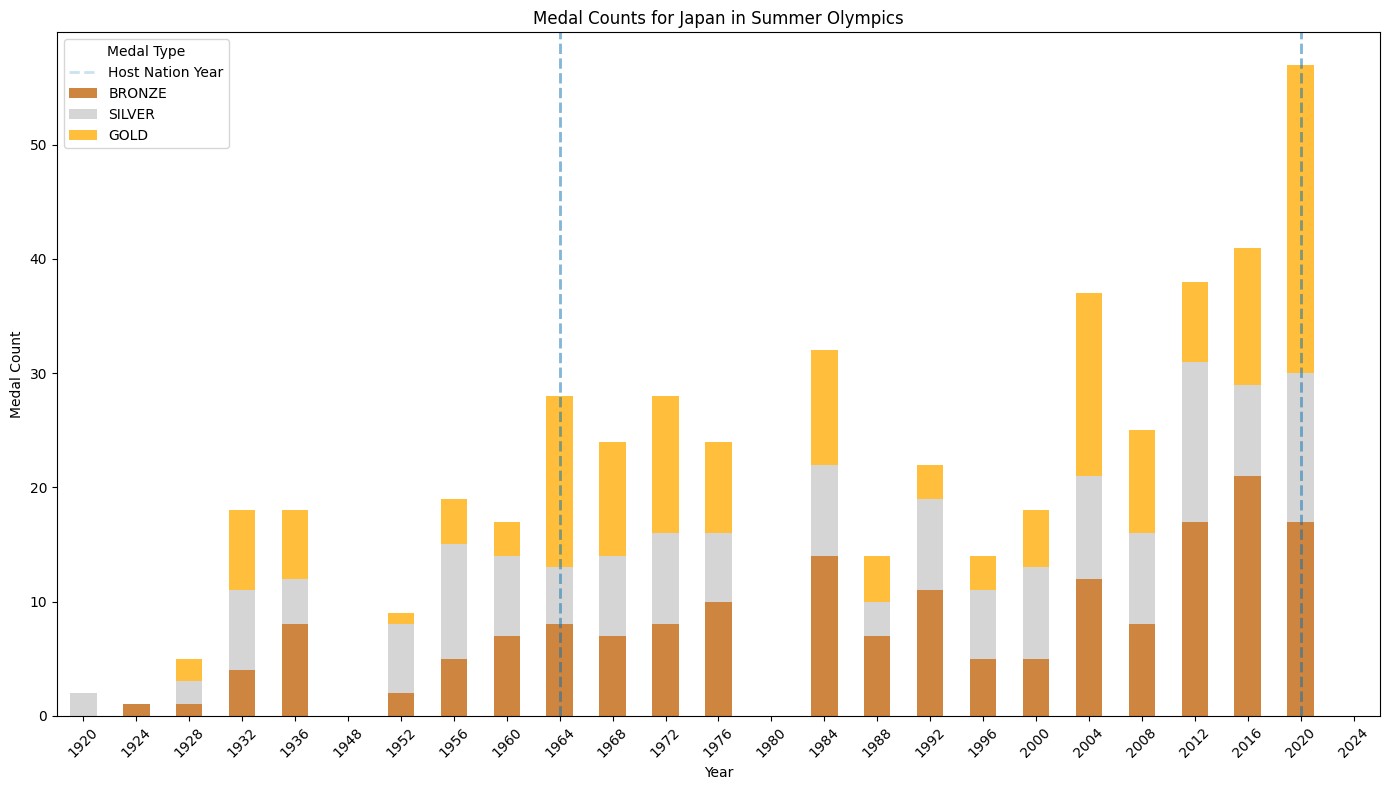

In [ ]:
visualize_stacked_bar_chart('Japan', 'Summer', year_start=1920)

<Figure size 1400x800 with 0 Axes>

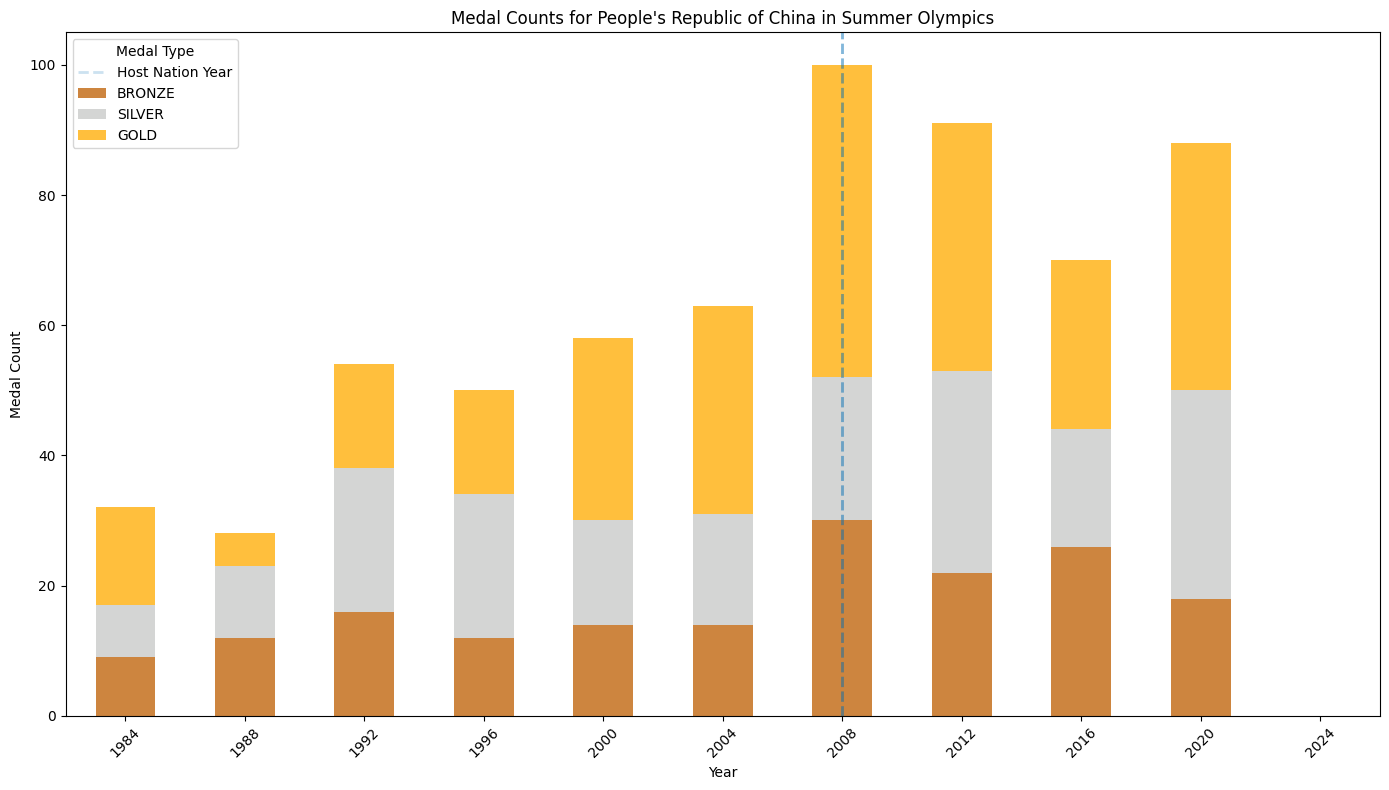

In [ ]:
visualize_stacked_bar_chart("People's Republic of China", 'Summer', year_start=1984)

<Figure size 1400x800 with 0 Axes>

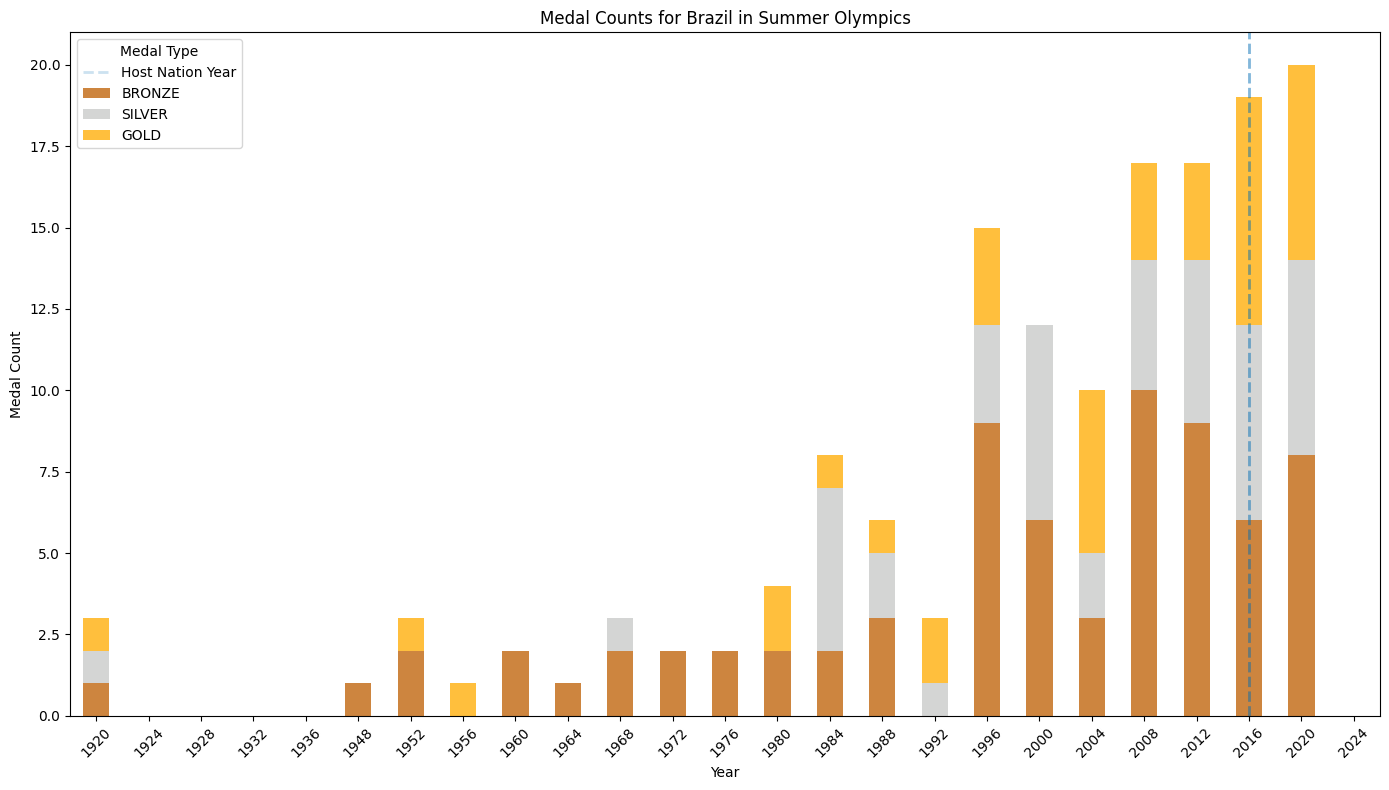

In [ ]:
visualize_stacked_bar_chart("Brazil", 'Summer', year_start=1920)

<Figure size 1400x800 with 0 Axes>

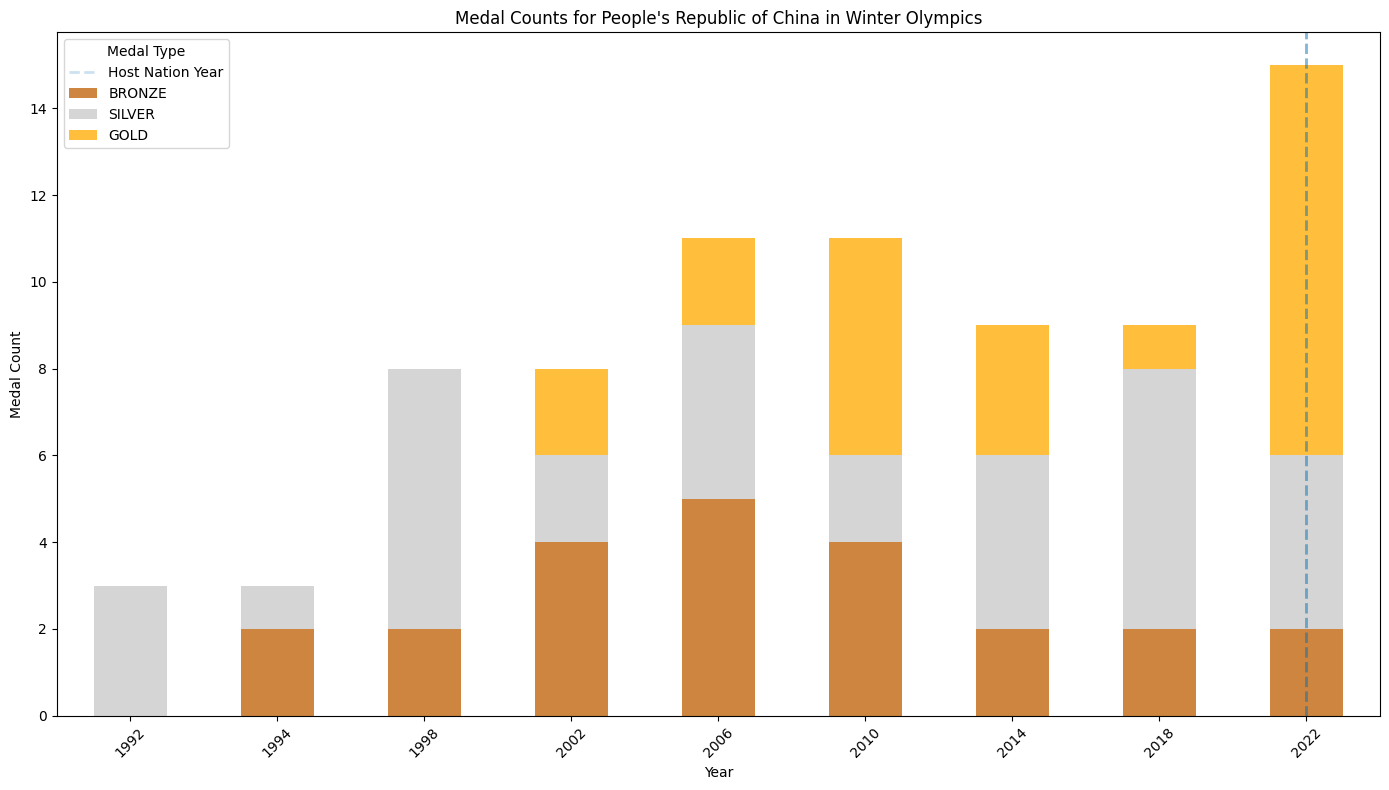

In [ ]:
visualize_stacked_bar_chart("People's Republic of China", 'Winter', year_start=1992)

<Figure size 1400x800 with 0 Axes>

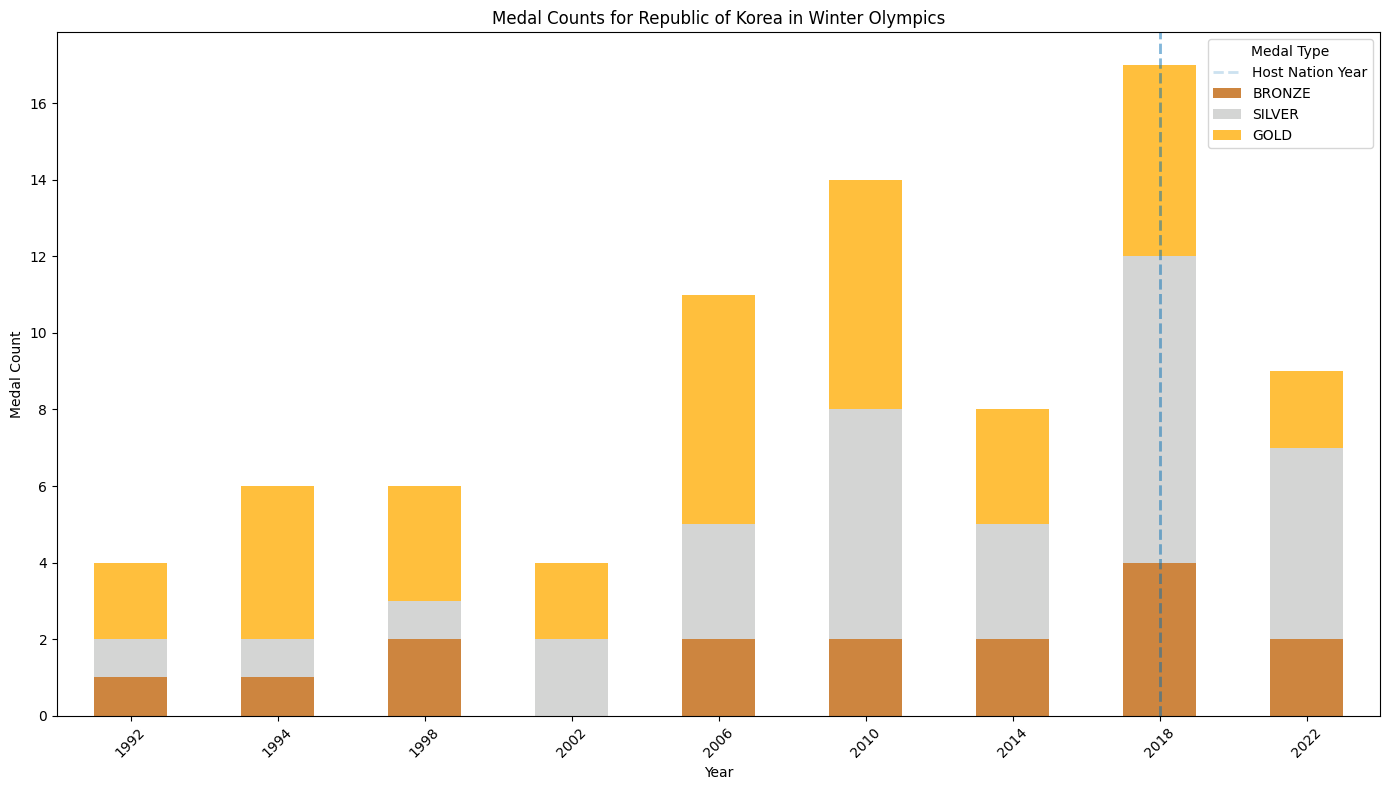

In [ ]:
visualize_stacked_bar_chart('Republic of Korea', 'Winter', year_start=1992)

<Figure size 1400x800 with 0 Axes>

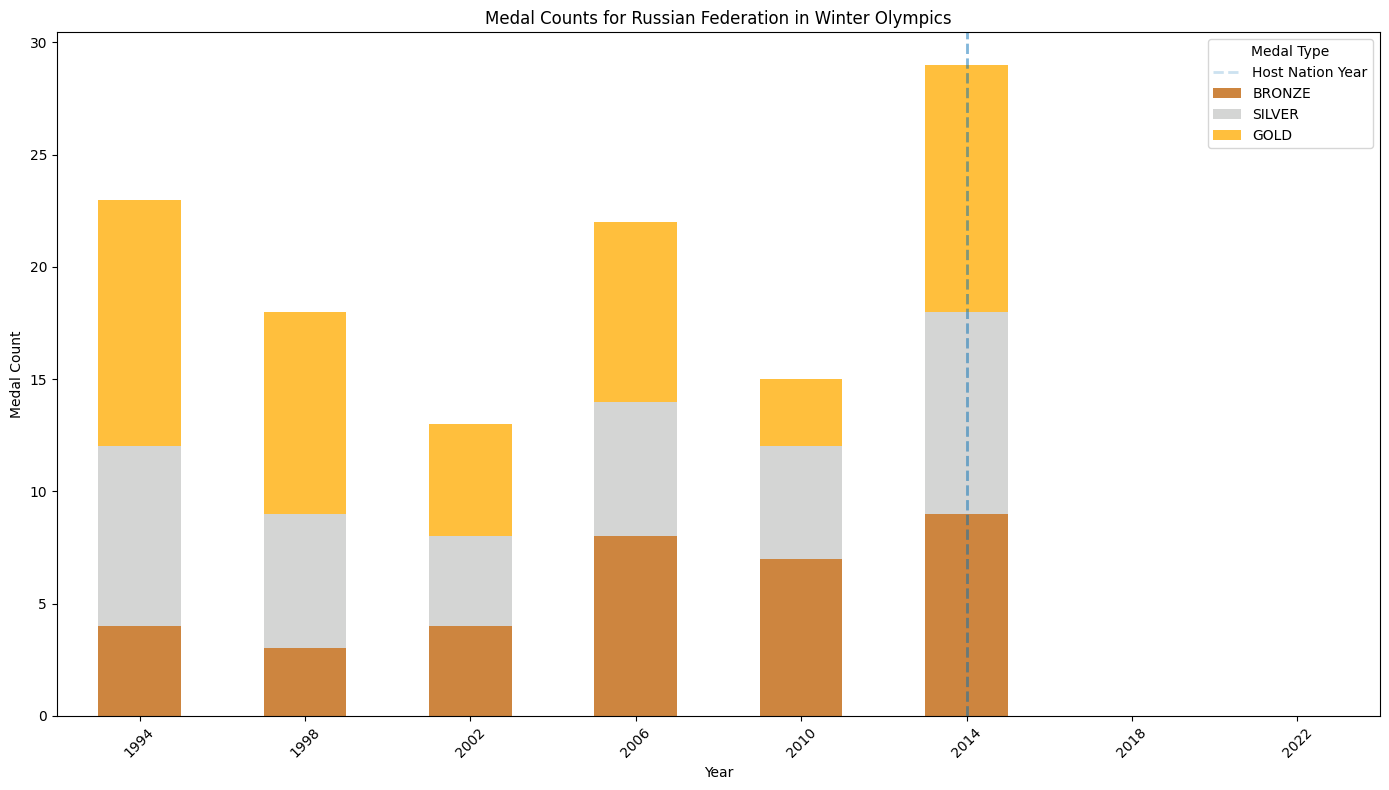

In [ ]:
visualize_stacked_bar_chart('Russian Federation', 'Winter', year_start=1994)

Interpretation:

All countries visualized above have achieved their all-time best medal counts at the Olympics during a host year. Japan and Brazil would go on to improve on their all-time best in subsequent games, but all other countries have not surpassed their host year medal counts. All host years have shown an improvement in the medal count when compared against medal counts in the previous games, but the relative difference varies from country to country.

Not only do countries see a greater medal count during host years, most also see the greatest number of gold medals during host years. Korea and Russia during the winter games are the exceptions, though Korea still saw the greatest number of silver medals during the host year.

Guided by observations from the previous graphs, this section checks each host year's medal counts to see if it is the newest all-time high medal count. Note that this analysis precludes data from before 1920 as the early Olympic games had low participation from many countries, and it was possible for a few countries to accrue very high medal counts.

In [ ]:
# Get total medal count for each country at each game
country_medal_count_query = """
SELECT
    s.country_name,
    o.year,
    o.season,
    SUM(s.medal_count) AS total_medal_count,
    s.country_name = o.host_nation AS is_host_nation
FROM
    Summary_Country_Medal_Count s
JOIN
    Olympic o ON s.olympic_id = o.olympic_id
GROUP BY
    s.country_name,
    o.year,
    o.season,
    is_host_nation
"""

country_medals_result_set = execute_sql_fetch(sqlite_connection, country_medal_count_query)
country_medals_df = pd.DataFrame(country_medals_result_set, columns=['country_name', 'year', 'season', 'medal_count', 'is_host_nation'])
country_medals_df['is_host_nation'] = country_medals_df['is_host_nation'].astype(bool)
country_medals_df = country_medals_df[country_medals_df['year'] >= 1920]
# Sort by country_name, season, and year
country_medals_df = country_medals_df.sort_values(by=['country_name', 'season', 'year'])

# Compute the cumulative maximum medal count for each country and season
country_medals_df['max_medal_count_up_to_now'] = country_medals_df.groupby(['country_name', 'season'])['medal_count'].cummax()

# Determine if the current medal count is the highest up to that year
country_medals_df['is_highest_up_to_now'] = country_medals_df['medal_count'] == country_medals_df['max_medal_count_up_to_now']

# Filter for host years
host_years_df = country_medals_df[country_medals_df['is_host_nation']]

# Count the number of host years that had the highest medal count up to that year
highest_up_to_now_count = host_years_df[host_years_df['is_highest_up_to_now']].shape[0]

# Count the number of host years that did not have the highest medal count up to that year
not_highest_up_to_now_count = host_years_df[~host_years_df['is_highest_up_to_now']].shape[0]
print(host_years_df)
print(f"Number of host years with highest medal count up to that year: {highest_up_to_now_count}")
print(f"Number of host years without highest medal count up to that year: {not_highest_up_to_now_count}")


                     country_name  year  season  medal_count  is_host_nation  \
47                      Australia  1956  Summer           35            True   
60                      Australia  2000  Summer           58            True   
93                        Austria  1964  Winter           12            True   
99                        Austria  1976  Winter            6            True   
161                       Belgium  1920  Summer           35            True   
214                        Brazil  2016  Summer           19            True   
273                        Canada  1976  Summer           11            True   
279                        Canada  1988  Winter            5            True   
290                        Canada  2010  Winter           26            True   
491   Federal Republic of Germany  1972  Summer           40            True   
515                       Finland  1952  Summer           20            True   
558                        France  1924 

This analysis shows that 35/48 or 73% of host years gave rise to a new all-time high medal count for the host country.

## 6.2 Normalized Medal Count
As the Olympic games have grown, more events have been added and the total number of medals achievable have increased over the years. Therefore, the medal count should be normalized to account for the increase in available medals. In this section, the medal counts are normalized by taking the medals won by a country at an Olympic game and dividing it by the total medals available at that game. The idea is to isolate for the effects of events being added to the games increasing medal count.

See the function `visualize_normalized_medal_counts` from section 6.0 for the queries used in this visualization.



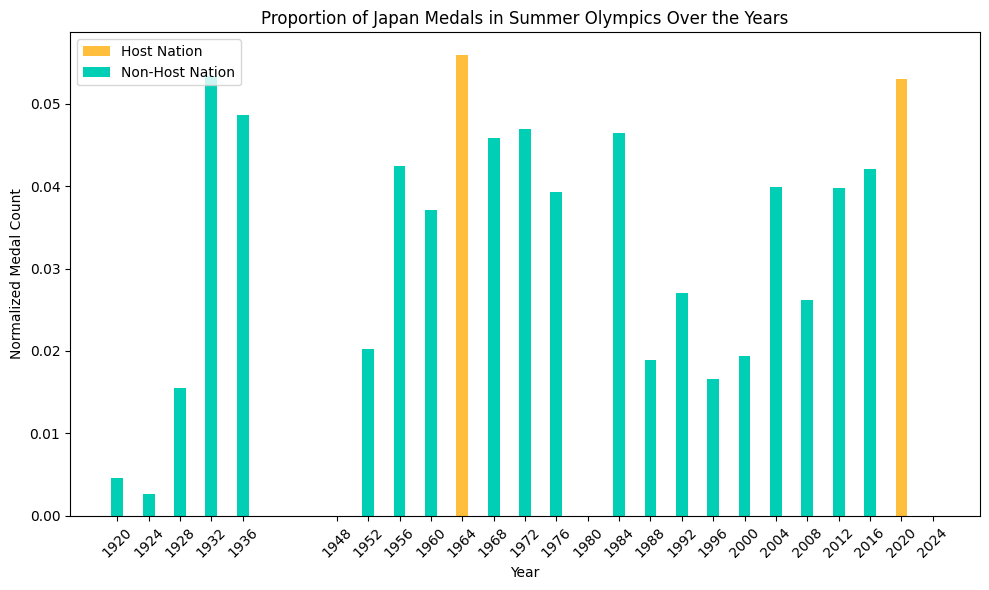

In [ ]:
visualize_normalized_medal_counts('Japan', 'Summer', year_start=1920)

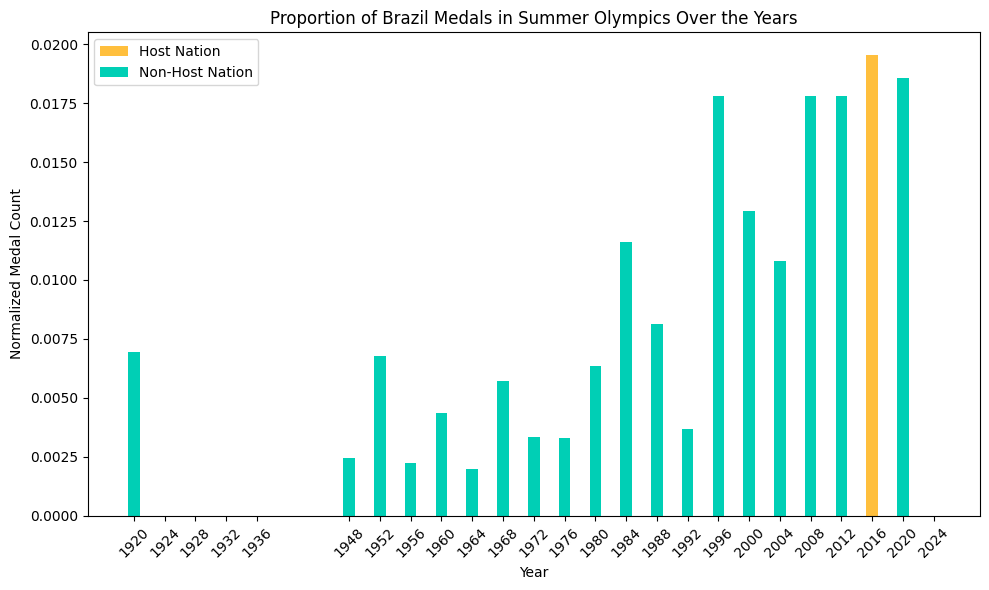

In [ ]:
visualize_normalized_medal_counts('Brazil', 'Summer', year_start=1920)

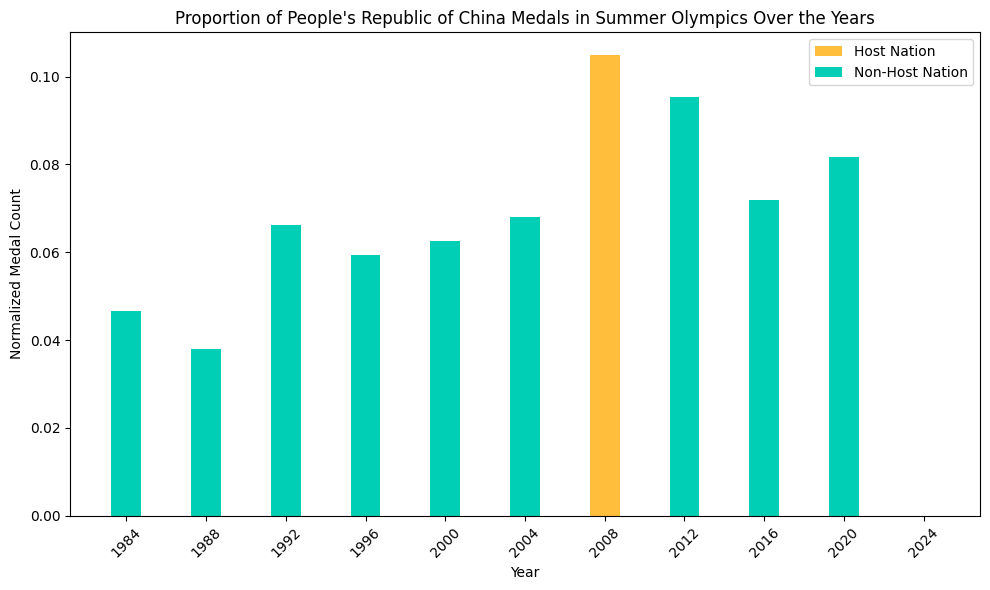

In [ ]:
visualize_normalized_medal_counts("People's Republic of China", 'Summer', year_start=1984)

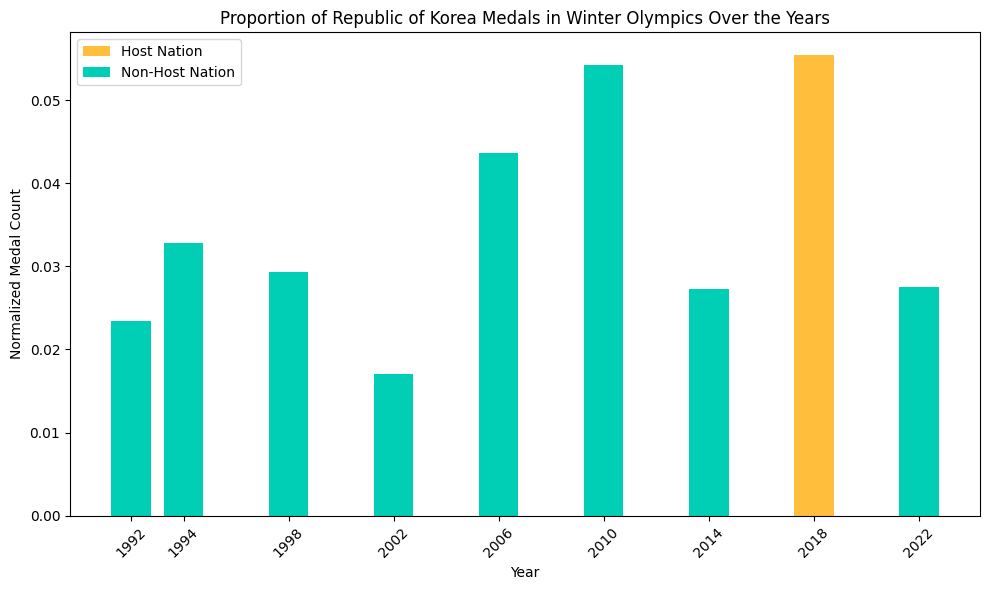

In [ ]:
visualize_normalized_medal_counts('Republic of Korea', 'Winter', year_start=1992)

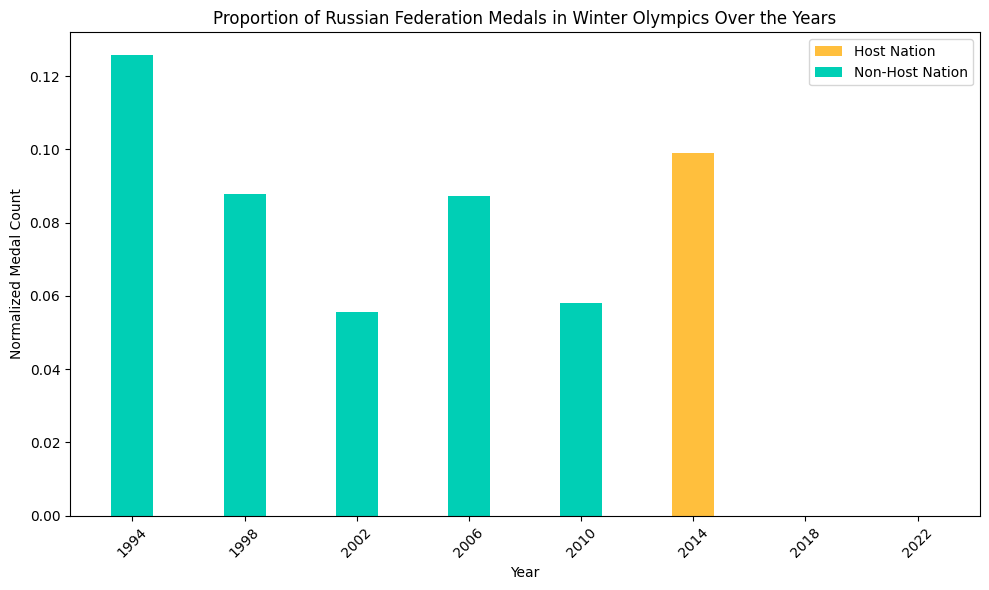

In [ ]:
visualize_normalized_medal_counts('Russian Federation', 'Winter', year_start=1994)

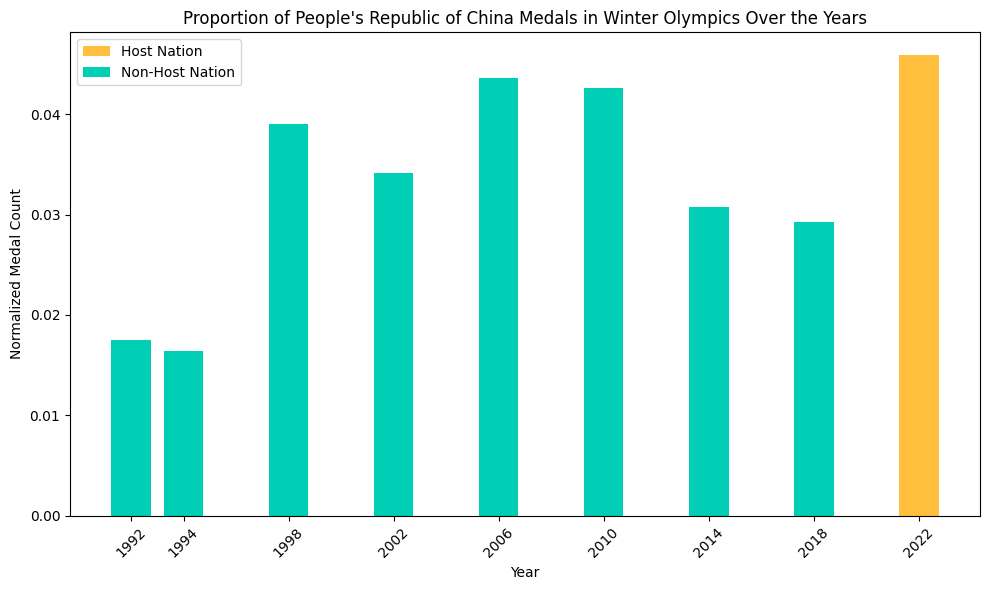

In [ ]:
visualize_normalized_medal_counts("People's Republic of China", 'Winter', year_start=1992)

Interpretation:

  Most countries, with the exception of Russia in the winter games, still see the greatest normalized medal counts during the host year, confirming that they win more of the available medals during host years.

  However, normalizing the medal count can highlight the medal gains from earlier years where total medal counts were lower. For example, while Japan earned fewer medals overall in the host year 1964 than in some of the later years, the normalized medal count that year is actually higher than even the normalized medal count in 2020.

This section checks each host year's normalized medal counts to see if it is the newest all-time high normalized medal count. Note that this analysis precludes data from before 1920 as the early Olympic games had low participation from many countries, and it was possible for a few countries to accrue a very hig proportion of medals.

In [ ]:
country_medals_df = pd.concat([get_host_nation_df('Summer'), get_host_nation_df('Winter')])

country_medals_df['is_host_nation'] = country_medals_df['is_host_nation'].astype(bool)
country_medals_df = country_medals_df[country_medals_df['year'] >= 1920]

# Sort by country_name, season, and year
country_medals_df = country_medals_df.sort_values(by=['country_name', 'season', 'year'])

# Compute the cumulative maximum medal count for each country and season
country_medals_df['max_normalized_medal_count_up_to_now'] = country_medals_df.groupby(['country_name', 'season'])['normalized_medal_count'].cummax()

# Determine if the current medal count is the highest up to that year
country_medals_df['is_highest_up_to_now'] = country_medals_df['normalized_medal_count'] == country_medals_df['max_normalized_medal_count_up_to_now']

# Filter for host years
host_years_df = country_medals_df[country_medals_df['is_host_nation']]

# Count the number of host years that had the highest medal count up to that year
highest_up_to_now_count = host_years_df[host_years_df['is_highest_up_to_now']].shape[0]

# Count the number of host years that did not have the highest medal count up to that year
not_highest_up_to_now_count = host_years_df[~host_years_df['is_highest_up_to_now']].shape[0]

columns_to_display = ['country_name', 'year', 'season', 'normalized_medal_count', 'max_normalized_medal_count_up_to_now', 'is_highest_up_to_now']

# Select only the specified columns from host_years_df
filtered_host_years_df = host_years_df[columns_to_display]

print(filtered_host_years_df)
print(f"Number of host years with highest normalized medal count up to that year: {highest_up_to_now_count}")
print(f"Number of host years without highest normalized  medal count up to that year: {not_highest_up_to_now_count}")


                     country_name  year  season  normalized_medal_count  \
728                     Australia  1956  Summer                0.078300   
365                     Australia  2000  Summer                0.062567   
303                       Austria  1964  Winter                0.115385   
349                       Austria  1976  Winter                0.054054   
1243                      Belgium  1920  Summer                0.080831   
452                        Brazil  2016  Summer                0.019527   
1270                       Canada  1976  Summer                0.018033   
402                        Canada  1988  Winter                0.036232   
99                         Canada  2010  Winter                0.100775   
906   Federal Republic of Germany  1972  Summer                0.067002   
695                       Finland  1952  Summer                0.045045   
537                        France  1924  Summer                0.091644   
211                      

This analysis shows that 38/48 or 79% of host years gave rise to a new all-time high normalized medal count for the host country.

## 6.3 Differences in Medal Count During Host Years

Country medal counts tend to trend up or down over time as the country becomes more or less competitive. As a result, average medal counts over time are not helpful when comparing against host years. For example, if a country is generally increasing in medal count, an all-time high at a hosting year that's at the tail end of the growth may have occurred anyway if that country did not host.

One way to deal with this is to limit the comparison to the games immediately before and after the hosting year because those are the closest temporally. Limited by time to perform more advanced analysis, we will make the assumption here that the general trend would have continued with or without hosting in the 12 year period. We will also use the differences in normalized medal count rather than absolute medal count to understand the change in proportion of medals won. The idea here is to use the below metrics to look for a local maximum at the host year.

The two metrics are:
*   Previous difference: host year normalized medal count minus previous year normalized medal count. A positive value means there was an increase in medal count during the host year from the last game.

*   Next difference: next year normalized medal count minus host year normalized medal count. A negative value means there was a decrease in medal count during the game following the host year.

Interpretation:

If the previous difference is positive, that means there was an increase in proportion of medals won during the host year. If the previous difference is negative, that means the host year actually won less proportion of medals.

If the next difference is negative, that means the increase in proportion of medals won in the host year is likely to be separate from the gengeral trend of increasing medal counts for that country. If the next difference is positive, however, it may be argued that the country was improving in medal count anyway and that the host year increase was just part of the trend.

If the countries do win more medals, we would expect to see a positive previous difference combined with a negative next difference.

Data filtering:

The data for the summer Olympics from 1976, 1980, 1984, and 1988 will be excluded from this analysis due to the effects of boycotts at those games. Very competitive countries like the US and Soviet Union were absent from the 1980 and 1984 games, so other countries will see an inflated proportion of medals won during those games. The data for the 1976 and 1988 games will be excluded because the next and previous differences for those years will be affected by the 1980 and 1984 boycotts, respectively.

See the function `get_host_nation_df` from section 6.0 for the query used in this visualization.

---



**Summer Olympics**

Of the 23 summer games under consideration, only 3 games showed a negative previous difference (decrease in proportion of medals won compared to the last game), and only 1 game showed a positive next difference (increase in proportion of medals won at the next game). This suggests that countries do win more medals when hosting as most countries see an increase in proportion of medals going into a host year and a decrease in proportion of medals coming out of a host year.

The magnitudes of the positive previous differences and negative next differences are greatest in the early Olympic games and taper off after 1948. In 1904, the host saw a 60% increase in the proportion of medals from the previous year. Between 1948 and 2016, no host country saw more than a 5% increase in the proportion of medals from the previous year. This suggests that host countries used to win a greater proportion of medals, but in modern games, the increase is much smaller.


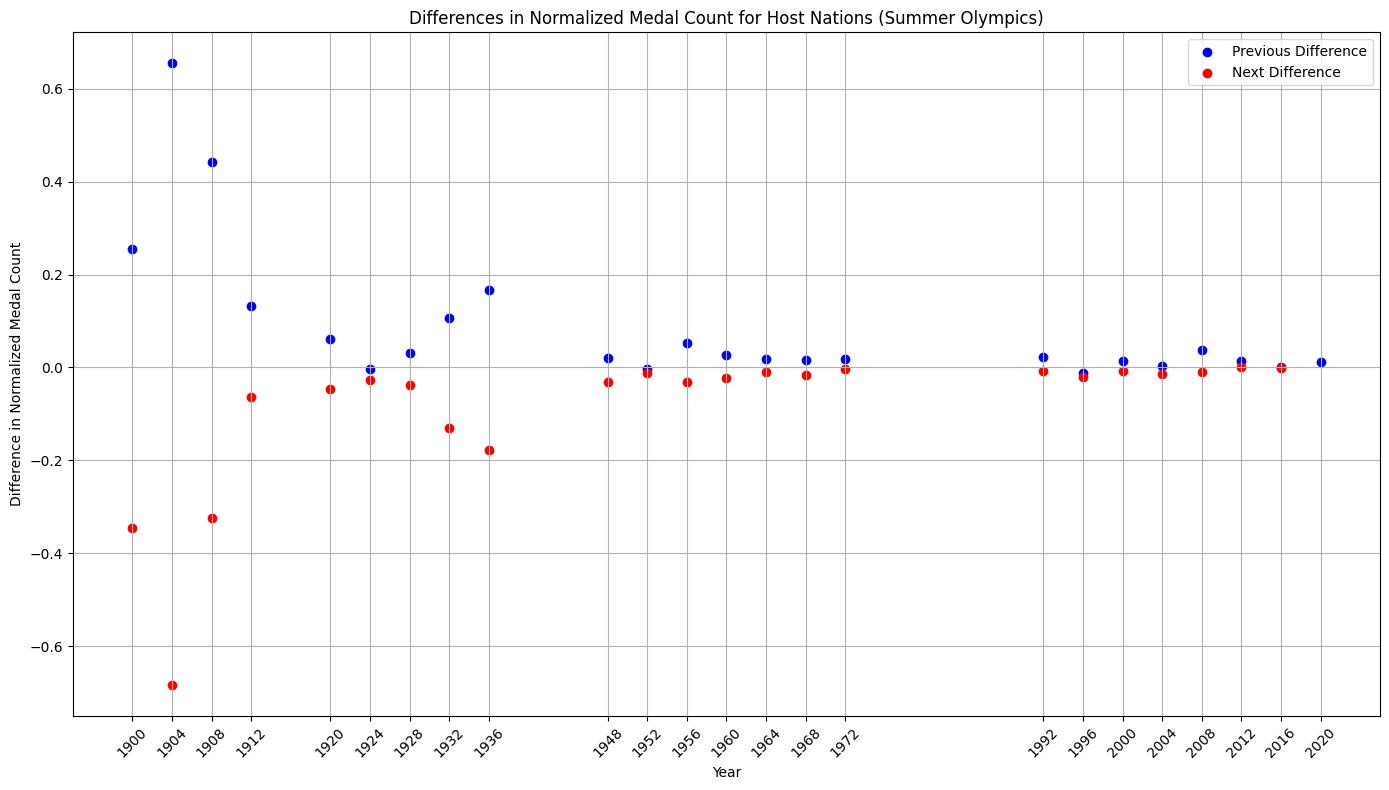

In [ ]:
df_query = '(1900 <= year <= 2024) & (year < 1976 or year > 1988)'
host_nation_df = get_host_nation_df('Summer')
visualize_host_nation_differences(host_nation_df, 'Summer', df_query)

Due to the large differences in early games, we limit the year range from 1948 to 2016 to show the modern game differences more clearly.

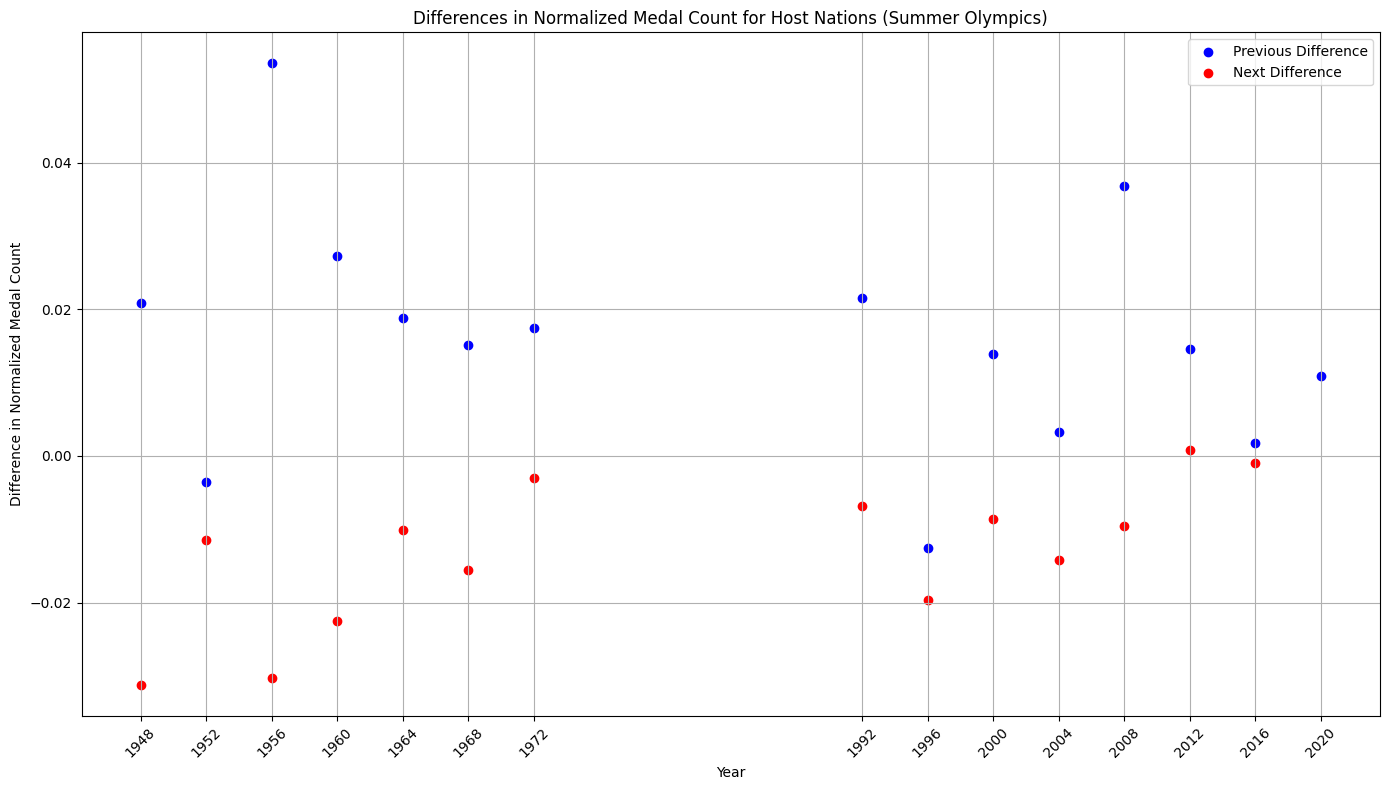

In [ ]:
df_query = '(1948 <= year <= 2024) & (year < 1976 or year > 1988)'
visualize_host_nation_differences(host_nation_df, 'Summer', df_query)

**Winter Olympics**

Note on missing data:
*   1924 - excluded due to being the first game
*   1984 - Yugoslavia did not compete at the previous Olympics
*   2014 - Russia was banned from the next Olympics

Trends similar to the summer Olympics can be observed. Overall, most games show a positive previous difference, with only 2 out of 22 games having negative previous differences. Most games also show a negative next difference, with only 4 games out of 22 having a positive next difference.

As in the summer games, the greatest difference magnitudes are seen in the earlier Olympic games. The magnitudes are generally comparable to those in the summer games. For early games winter, the differences are lower than those seen in early summer games. For modern era games, the differences remain under 5%, which is similar to those of the summer games.

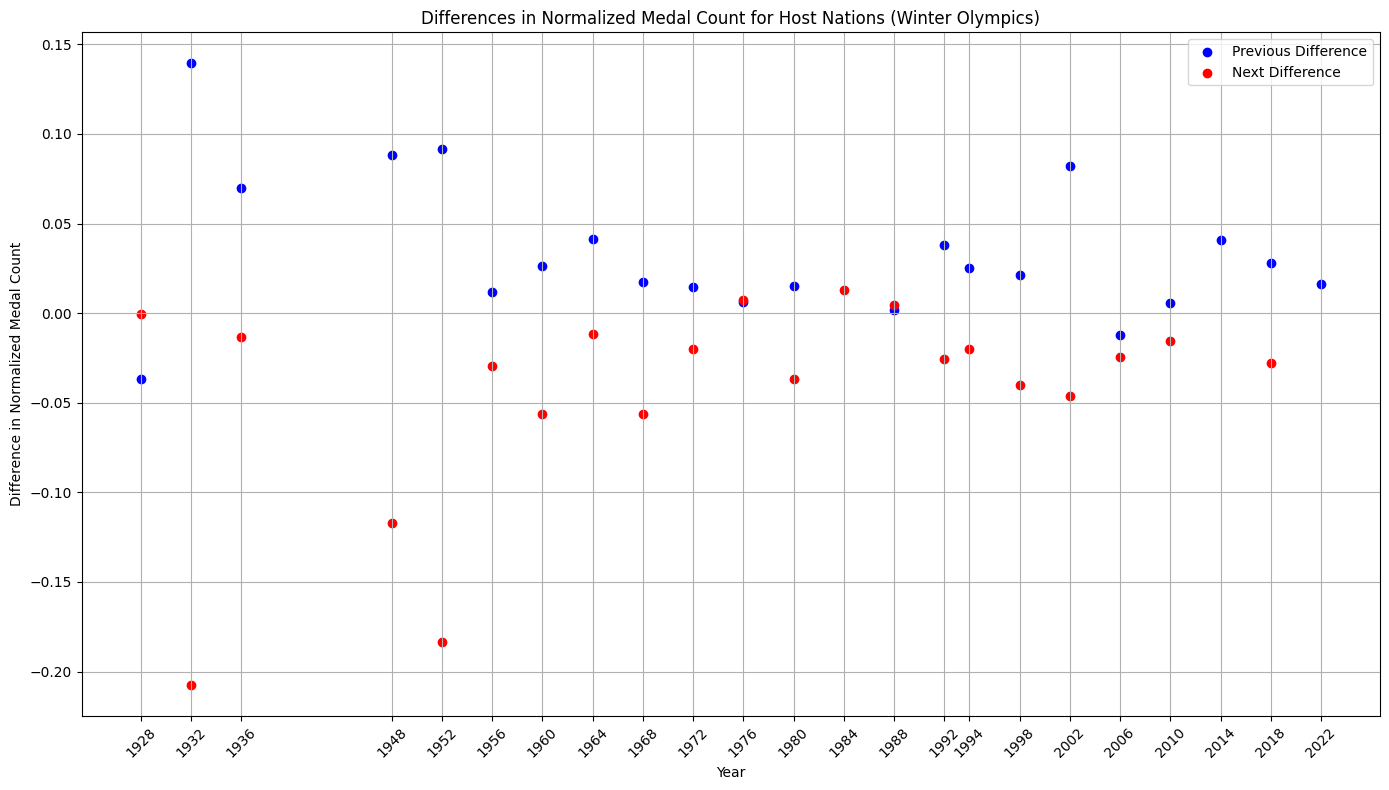

In [ ]:
host_nation_df = get_host_nation_df('Winter')
df_query = '(1928 <= year <= 2024)'
visualize_host_nation_differences(host_nation_df, 'Winter', df_query)

# 7.0 Conclusion

## 7.1 Takeaways

*   73% of host years gave rise to a new all-time high medal count for the host country.
*   79% of host years gave rise to a new all-time high normalized medal count for the host country.
*   The host country saw much greater increases in proportion of available medals won in earlier Olympics as compared to games from the modern era.
*   Most countries saw an increase in proportion of available medals won going from the previous game to the host year. Most countries also saw a decrease in proportion of available medals won going into the game subsequent to the host year. This trend is intepreted to indicate that the proportion of medals won during a host year generally increases above the performance trend for the host country.

*   There is no major difference in the increase in absolute or relative medal during host years for summer and winter Olympic games.

We have examined the hypothesis by examining the total medal count and the proportion of available medals won in host and non-host years. We found that most of the time, countries do win more medals during host years than in non-host years, even when accounting for the inflation of available medals over time. Countries have historically earned all-time high proportions of medals during most host years. In addition, the proportion of medals won tends to drop off in the game following the host year, signaling a local increase in medals during the host year. Finally, the increase in medals won during host years is greatest in early Olympic games, and drops off in modern Olympic games after 1948.


Future work can focus on breaking down the makeup of medals by gender, individual vs team sport, and disciplines to see how hosting affects medal count in these categories. There were plans to examine these categories, but we were limited in by time constraints. In addition, more advanced statistic techniques can be used to categorize hostyears as local maximums. The non-host years can be fitted to a model to predict what the medal count would have been in the host year if that country did not host.


## 7.2 Limitations



*   Data quality issues <br>
    The original dataset contained a large amount of data quality issues, including missing values, inconsistencies, and other errors that needed to be resolved before the data could be used for analysis. Most of the data quality issues were resolved during the data cleaning process, espcially those related to data type conversion and missing values etc., but some were natually unavoidable as they were due to to cultural, social, and political factors, and many of the issues were not noticed until the data was analyzed and intially visualized.

*   Data selection <br>
    The data selected for the project was based on the availability, reliability, and most importantly the relevance to the project's focal point and hypotheses. As a result, data considered to be less relevant for the interpretation of the project's results were excluded from the final dataset, but what remained was consistent, sufficient and representative enough to support the hypothesis formulated.

*   Time constraints <br>
    The project was completed within a 2-week timeframe, a period not too short but still somewhat limited for a project to be executed in a further detailed manner, or scaled up to include analyses from all other perspectives such as data from other sectors like GDP, population, and other socio-economic factors. As a result, the project aims to provide a informative analysis with enough insights to support and explore the focal point, but intend not to be refered to as a comprehensive analysis of Olympic Games in general.

*   Bias <br>
    The project may contain biases that are inherent to the data, the analysis, and the interpretation of the results. The team acknowledges the potential biases that may be associated with the project, and has taken actions needed to minimize such effects. However, it is still important for the reader to be aware of the possible biases that may be present in the project, and is encouraged to review the project with discretion.




# 8.0 Prediction
## Which country will win the most medals in 2024 Summer Olympic?

In [ ]:
# Prepare the data to train the model
query = """
WITH MedalData AS (
    SELECT
        o.year,
        o.host_nation,
        r.country_name,
        COUNT(r.medal_type) AS medal_count,
        o.season
    FROM
        Result r
    JOIN
        Olympic o ON r.olympic_id = o.olympic_id
    WHERE
        r.country_name IN ('United States of America', 'People''s Republic of China', 'Great Britain', 'France', 'Italy', 'Hungary', 'Japan', 'Australia')
        AND o.season = 'Summer'
        AND o.year >= 1980
    GROUP BY
        o.year, o.host_nation, r.country_name
)
SELECT
    m.year,
    m.country_name,
    m.medal_count,
    CASE
        WHEN m.country_name = m.host_nation THEN 1
        ELSE 0
    END AS is_hosting
FROM
    MedalData m
JOIN
    Olympic o ON m.year = o.year AND o.season = 'Summer'
ORDER BY
    m.year, m.country_name;
"""

df_predict = pd.read_sql(query, conn)
print(df_predict.head())
print(df_predict.tail())

   year   country_name  medal_count  is_hosting
0  1972      Australia           17           0
1  1972         France           13           0
2  1972  Great Britain           18           0
3  1972        Hungary           35           0
4  1972          Italy           18           0
    year                country_name  medal_count  is_hosting
93  2020                     Hungary           20           0
94  2020                       Italy           40           0
95  2020                       Japan           57           1
96  2020  People's Republic of China           88           0
97  2020    United States of America          113           0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# One-hot encode the 'country_name' column
df_encoded = pd.get_dummies(df_predict, columns=['country_name'])

X = df_encoded.drop('medal_count', axis=1)  # features
y = df_encoded['medal_count']  # target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 63.34882500000001


In [ ]:
future_data = {
    'country_name': ['United States of America', 'People\'s Republic of China', 'Great Britain', 'France', 'Italy', 'Hungary', 'Japan', 'Australia'],
    'is_hosting': [0, 0, 0, 1, 0, 0, 0, 0]  # Only France is hosting
}

# Convert dictionary to DataFrame
df_2024 = pd.DataFrame(future_data)

# One-hot encode the 'country_name' as done in the training dataset
df_2024_encoded = pd.get_dummies(df_2024, columns=['country_name'])

# Ensure the 2024 data frame has all columns used in the model, filling missing with zeros
for col in X_train.columns:
    if col not in df_2024_encoded:
        df_2024_encoded[col] = 0  # Add missing columns as zeros

# Ensure column order matches that of X_train for consistency
df_2024_encoded = df_2024_encoded[X_train.columns]


In [ ]:
# Predict using the model
predicted_medals_2024 = model.predict(df_2024_encoded)

# Add the predicted medals back to the df_2024 for better readability
df_2024['predicted_medals'] = predicted_medals_2024
print(df_2024[['country_name', 'predicted_medals']])


                 country_name  predicted_medals
0    United States of America             99.15
1  People's Republic of China             32.35
2               Great Britain             17.44
3                      France             34.49
4                       Italy             15.10
5                     Hungary             28.35
6                       Japan             21.83
7                   Australia             12.43


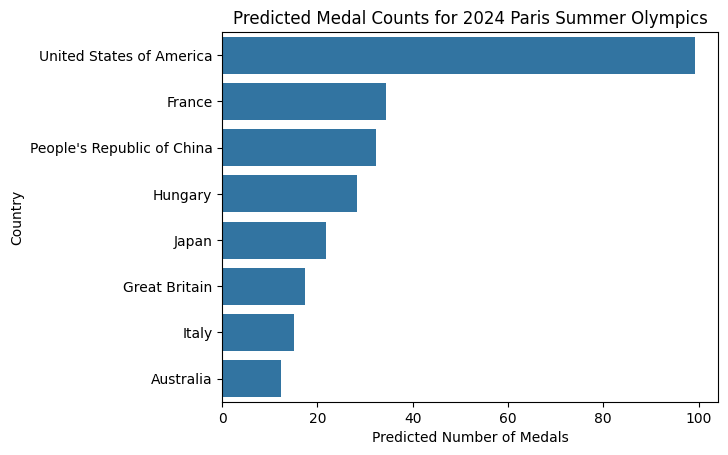

In [ ]:
# Visualization
import seaborn as sns
sns.barplot(x='predicted_medals', y='country_name', data=df_2024.sort_values(by='predicted_medals', ascending=False))
plt.title('Predicted Medal Counts for 2024 Paris Summer Olympics')
plt.xlabel('Predicted Number of Medals')
plt.ylabel('Country')
plt.show()
